# 🏗️Import Necessary Libraries

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNetV2
from keras import Model
# from layers.experimental import preprocessing
# Corrected import statement for TensorFlow's experimental preprocessing
from tensorflow.keras.layers.experimental import preprocessing


# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# 🤙Create helper functions

In [2]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    

# 📥Load and transform data

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [4]:
# Walk through each directory
dataset = "D:/6th sem/Minor 2/Orginal/Poses"
walk_through_dir(dataset)

There are 47 directories and 1 images in 'D:/6th sem/Minor 2/Orginal/Poses'.
There are 0 directories and 74 images in 'D:/6th sem/Minor 2/Orginal/Poses\Adho Mukha Svanasana'.
There are 0 directories and 65 images in 'D:/6th sem/Minor 2/Orginal/Poses\Adho Mukha Vrksasana'.
There are 0 directories and 18 images in 'D:/6th sem/Minor 2/Orginal/Poses\Alanasana'.
There are 0 directories and 71 images in 'D:/6th sem/Minor 2/Orginal/Poses\Anjaneyasana'.
There are 0 directories and 59 images in 'D:/6th sem/Minor 2/Orginal/Poses\Ardha Chandrasana'.
There are 0 directories and 96 images in 'D:/6th sem/Minor 2/Orginal/Poses\Ardha Matsyendrasana'.
There are 0 directories and 13 images in 'D:/6th sem/Minor 2/Orginal/Poses\Ardha Navasana'.
There are 0 directories and 54 images in 'D:/6th sem/Minor 2/Orginal/Poses\Ardha Pincha Mayurasana'.
There are 0 directories and 12 images in 'D:/6th sem/Minor 2/Orginal/Poses\Ashta Chandrasana'.
There are 0 directories and 81 images in 'D:/6th sem/Minor 2/Orginal/

# 📅Placing data into a Dataframe
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [5]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
image_df

Filepath                 Label
0     D:\6th sem\Minor 2\Orginal\Poses\Adho Mukha Sv...  Adho Mukha Svanasana
1     D:\6th sem\Minor 2\Orginal\Poses\Ardha Navasan...        Ardha Navasana
2     D:\6th sem\Minor 2\Orginal\Poses\Baddha Konasa...       Baddha Konasana
3     D:\6th sem\Minor 2\Orginal\Poses\Baddha Konasa...       Baddha Konasana
4     D:\6th sem\Minor 2\Orginal\Poses\Baddha Konasa...       Baddha Konasana
...                                                 ...                   ...
4705  D:\6th sem\Minor 2\Orginal\Poses\Vrksasana\Fil...             Vrksasana
4706  D:\6th sem\Minor 2\Orginal\Poses\Vrksasana\Fil...             Vrksasana
4707  D:\6th sem\Minor 2\Orginal\Poses\Vrksasana\Fil...             Vrksasana
4708  D:\6th sem\Minor 2\Orginal\Poses\Vrksasana\Fil...             Vrksasana
4709  D:\6th sem\Minor 2\Orginal\Poses\Vrksasana\Fil...             Vrksasana

[4710 rows x 2 columns]

# 🔭Visualizing images from the dataset

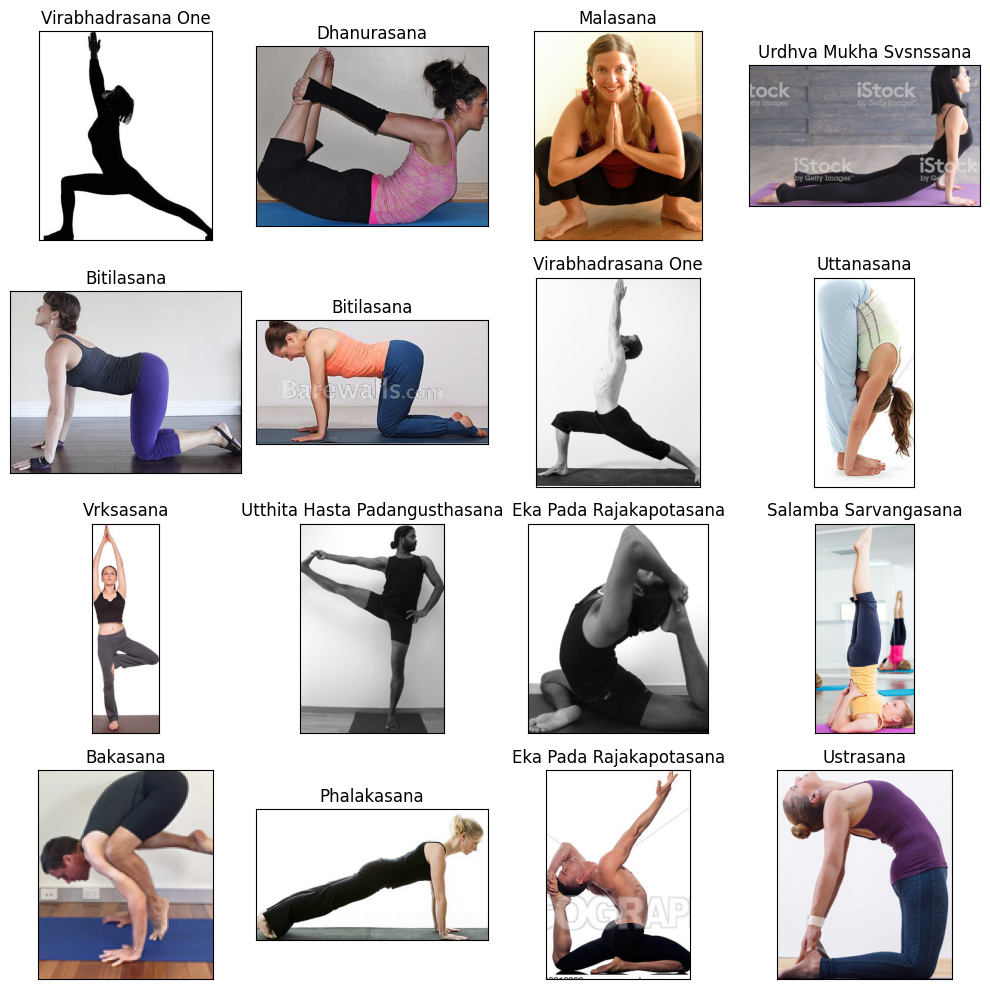

In [7]:
# Display 9 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# 🧮Computing Error Rate Analysis

In [8]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

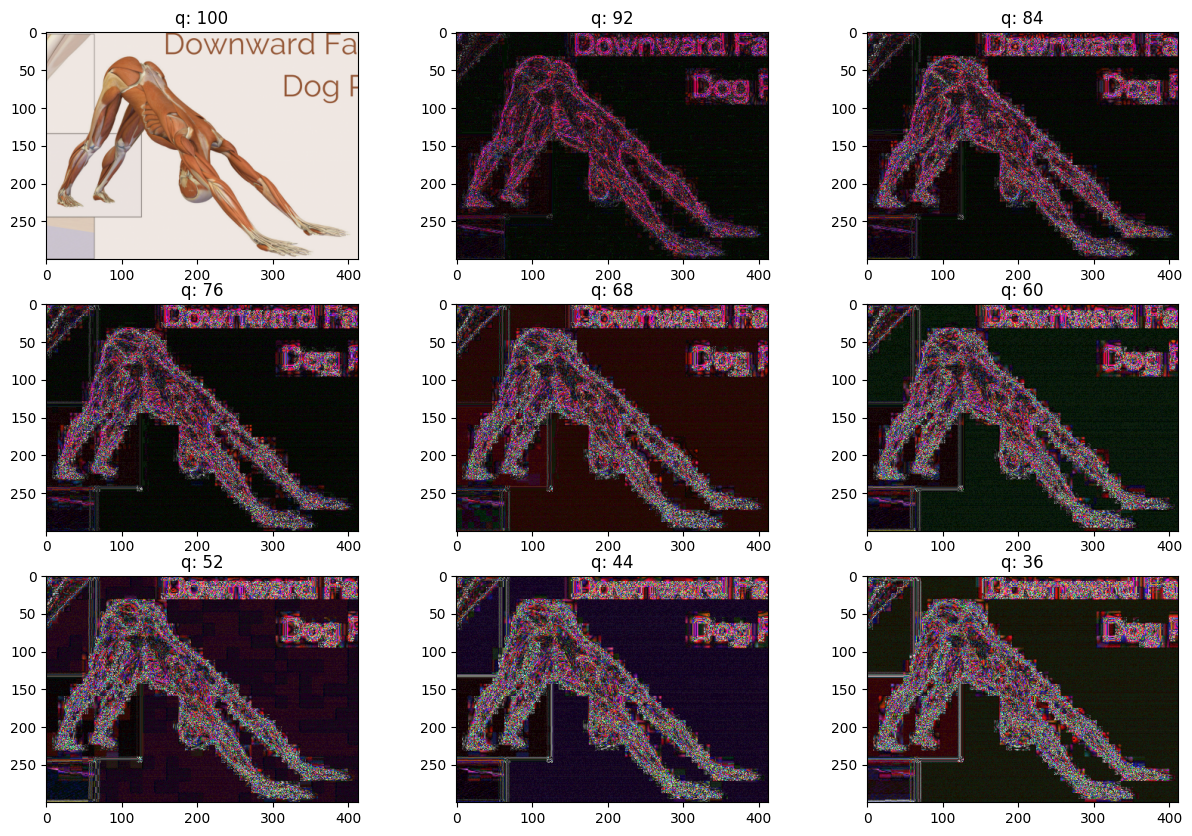

In [9]:
# View random sample from the dataset
p = random_sample('D:/6th sem/Minor 2/Orginal/Poses/Adho Mukha Svanasana')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

# 📝Data Preprocessing
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).</p>

In [10]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [12]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming 'image_df' contains all data with 'Filepath' and 'Label' columns
# Re-split with stratification
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, stratify=image_df['Label'], random_state=1)

# Further split train_df into train and validation (stratified)
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, stratify=train_df['Label'], random_state=1)

print("Classes in training set:", set(train_df['Label'].unique()))
print("Classes in validation set:", set(val_df['Label'].unique()))
print("Classes in test set:", set(test_df['Label'].unique()))


Classes in training set: {'Bakasana', 'Anjaneyasana', 'Dhanurasana', 'Padmasana', 'Setu Bandha Sarvangasana', 'Virabhadrasana Two', 'Ardha Pincha Mayurasana', 'Marjaryasana', 'Sivasana', 'Vasisthasana', 'Virabhadrasana Three', 'Parsvottanasana', 'Balasana', 'Baddha Konasana', 'Ardha Navasana', 'Supta Kapotasana', 'Salamba Bhujangasana', 'Bitilasana', 'Ustrasana', 'Garudasana', 'Adho Mukha Svanasana', 'Hanumanasana', 'Salamba Sarvangasana', 'Urdhva Mukha Svsnssana', 'Utthita Parsvakonasana', 'Eka Pada Rajakapotasana', 'Phalakasana', 'Halasana', 'Ardha Chandrasana', 'Uttanasana', 'Ardha Matsyendrasana', 'Pincha Mayurasana', 'Urdhva Dhanurasana', 'Ashta Chandrasana', 'Virabhadrasana One', 'Adho Mukha Vrksasana', 'Malasana', 'Paschimottanasana', 'Alanasana', 'Utthita Hasta Padangusthasana', 'Utkatasana', 'Camatkarasana', 'Vrksasana'}
Classes in validation set: {'Anjaneyasana', 'Dhanurasana', 'Bakasana', 'Padmasana', 'Virabhadrasana Two', 'Setu Bandha Sarvangasana', 'Marjaryasana', 'Ardha P

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generators with the same preprocessing function
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2  # Only needed for splitting training and validation
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

# Create new train, validation, and test generators
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'  # No need for `subset='validation'` when using a separate val_df
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 2412 validated image filenames belonging to 43 classes.
Found 604 validated image filenames belonging to 43 classes.
Found 942 validated image filenames belonging to 43 classes.


In [14]:
train_classes = set(train_images.class_indices.keys())
val_classes = set(val_images.class_indices.keys())
test_classes = set(test_images.class_indices.keys())

print("Classes in training set:", train_classes)
print("Classes in validation set:", val_classes)
print("Classes in test set:", test_classes)

missing_classes = train_classes - test_classes
print("Classes missing in test set:", missing_classes)


Classes in training set: {'Anjaneyasana', 'Bakasana', 'Dhanurasana', 'Padmasana', 'Setu Bandha Sarvangasana', 'Virabhadrasana Two', 'Ardha Pincha Mayurasana', 'Marjaryasana', 'Sivasana', 'Vasisthasana', 'Virabhadrasana Three', 'Parsvottanasana', 'Balasana', 'Ardha Navasana', 'Baddha Konasana', 'Supta Kapotasana', 'Salamba Bhujangasana', 'Bitilasana', 'Garudasana', 'Adho Mukha Svanasana', 'Hanumanasana', 'Ustrasana', 'Salamba Sarvangasana', 'Urdhva Mukha Svsnssana', 'Utthita Parsvakonasana', 'Eka Pada Rajakapotasana', 'Halasana', 'Phalakasana', 'Ardha Chandrasana', 'Uttanasana', 'Ardha Matsyendrasana', 'Pincha Mayurasana', 'Ashta Chandrasana', 'Urdhva Dhanurasana', 'Malasana', 'Adho Mukha Vrksasana', 'Virabhadrasana One', 'Paschimottanasana', 'Alanasana', 'Utthita Hasta Padangusthasana', 'Utkatasana', 'Camatkarasana', 'Vrksasana'}
Classes in validation set: {'Anjaneyasana', 'Bakasana', 'Dhanurasana', 'Padmasana', 'Setu Bandha Sarvangasana', 'Virabhadrasana Two', 'Ardha Pincha Mayurasana

In [15]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(224,224),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),                       
], name="data_augmentation")

# 🤹Training the model
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:</p>

**Batch size** : 32

**Epochs** : 100

**Input Shape** : (224, 224, 3)

**Output layer** : 43



In [19]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [17]:
# Create checkpoint callback
checkpoint_path = "yoga_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [47]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=20,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

# 🚄Train the model

In [19]:
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [20]:
import datetime

In [21]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(43, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "yoga_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/yoga_classification/20240521-014901
Epoch 1/100
45/76 [================>.............] - ETA: 16s - loss: 3.9807 - accuracy: 0.0285

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


76/76 [==============================] - 59s 731ms/step - loss: 3.9407 - accuracy: 0.0319 - val_loss: 3.7895 - val_accuracy: 0.0430
Epoch 2/100
76/76 [==============================] - 50s 661ms/step - loss: 3.8766 - accuracy: 0.0357 - val_loss: 3.7272 - val_accuracy: 0.0480
Epoch 3/100
76/76 [==============================] - 52s 686ms/step - loss: 3.7988 - accuracy: 0.0415 - val_loss: 3.6772 - val_accuracy: 0.0563
Epoch 4/100
76/76 [==============================] - 50s 659ms/step - loss: 3.7494 - accuracy: 0.0522 - val_loss: 3.6367 - val_accuracy: 0.0778
Epoch 5/100
76/76 [==============================] - 50s 663ms/step - loss: 3.6965 - accuracy: 0.0618 - val_loss: 3.6003 - val_accuracy: 0.0861
Epoch 6/100
76/76 [==============================] - 51s 673ms/step - loss: 3.6538 - accuracy: 0.0705 - val_loss: 3.5671 - val_accuracy: 0.0977
Epoch 7/100
76/76 [==============================] - 48s 637ms/step - loss: 3.6020 - accuracy: 0.0730 - val_loss: 3.5350 - val_accuracy: 0.1010
Epoc

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                              

In [25]:
# print(test_images.shape)
print(model.input_shape)


(None, 224, 224, 3)


In [26]:
results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.15754
Test Accuracy: 73.78%


In [122]:
from tensorflow.keras.models import load_model
loaded_model=load_model("D:/6th sem/Minor 2/Baseline model/Baseline model/Saved models/baseline_model.h5")

In [123]:
results =loaded_model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.15754
Test Accuracy: 73.78%


In [27]:
# Convert to a TensorFlow Lite model

converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()
# Save the models as files:

import pathlib

tflite_models_dir = pathlib.Path("Saved models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmppce8fpv3\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmppce8fpv3\assets


In [28]:
# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"yoga_model.tflite"
tflite_model_file.write_bytes(tflite_model)

13184148

In [29]:
model.save('Baseline model/Saved models/baseline_model.h5')

## Waste

In [26]:
model.save("Saved models/initial_model")

INFO:tensorflow:Assets written to: Saved models/initial_model\assets


INFO:tensorflow:Assets written to: Saved models/initial_model\assets


In [124]:
# Convert to a TensorFlow Lite model

converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpaqe2zej_\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpaqe2zej_\assets


In [125]:
# Save the models as files:

import pathlib

tflite_models_dir = pathlib.Path("Post/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [29]:
# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"yoga_model.tflite"
tflite_model_file.write_bytes(tflite_model)

13184148

In [134]:
# Passing the Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
 
# Using float-16 quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
 
# Converting the model.
tflite_fp16_model = converter.convert()
 
# Saving the model.
with open('Post/fp_16_model.tflite', 'wb') as f:
  f.write(tflite_fp16_model)

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmp36jf71d3\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmp36jf71d3\assets


In [39]:
import numpy as np

# Initialize empty lists to store images and labels
test_images_list = []
test_labels_list = []

# Iterate through the batches in the test_images generator
for i in range(len(test_images)):
    images, labels = test_images[i]
    for img, lbl in zip(images, labels):
        test_images_list.append(img)
        test_labels_list.append(lbl)

# Convert lists to numpy arrays if needed
test_images_array = np.array(test_images_list)
test_labels_array = np.array(test_labels_list)

# Print shapes to verify
print("Test images shape:", test_images_array.shape)
print("Test labels shape:", test_labels_array.shape)


Test images shape: (942, 224, 224, 3)
Test labels shape: (942, 43)


In [40]:
import numpy as np
import tensorflow as tf

# Ensure test_labels_list is a numpy array with the correct dtype
test_labels_array = np.array(test_labels_list, dtype=int)

# Convert one-hot encoded test labels to single-label format
test_labels_single = np.argmax(test_labels_array, axis=1)

# Check the type and content of test_labels_single
print(f"Type of test_labels_single: {type(test_labels_single)}")
print(f"Dtype of test_labels_single: {test_labels_single.dtype}")
print(f"Shape of test_labels_single: {test_labels_single.shape}")
print(f"Contents of test_labels_single: {test_labels_single[:10]}")  # Print first 10 elements for checking

def evaluate(interpreter):
    prediction = []
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_format = interpreter.get_input_details()[0]['dtype']  # Correct the input format fetching

    for i, test_image in enumerate(test_images_list):
        if i % 100 == 0:
            print(f'Evaluated on {i} results so far.')
        
        test_image = np.expand_dims(test_image, axis=0).astype(input_format)
        interpreter.set_tensor(input_index, test_image)

        # Run inference
        interpreter.invoke()
        output = interpreter.get_tensor(output_index)  # Use get_tensor instead of tensor()
        predicted_label = np.argmax(output[0])
        prediction.append(predicted_label)
    
    print('\n')
    # Comparing prediction results with ground truth labels to calculate accuracy
    prediction = np.array(prediction, dtype=int)
    
    # Debugging output for predictions and labels
    print(f"Type of prediction array: {type(prediction)}")
    print(f"Dtype of prediction array: {prediction.dtype}")
    print(f"Shape of prediction array: {prediction.shape}")
    print(f"Contents of prediction array: {prediction[:10]}")  # Print first 10 elements for checking
    print(f"Shape of test_labels_single: {test_labels_single.shape}")
    print(f"Contents of test_labels_single: {test_labels_single[:10]}")  # Print first 10 elements for checking

    # Check if shapes of prediction and test_labels_single match
    if prediction.shape != test_labels_single.shape:
        print("Shape mismatch between predictions and test labels")
        return None

    accuracy = (prediction == test_labels_single).mean()
    return accuracy

Type of test_labels_single: <class 'numpy.ndarray'>
Dtype of test_labels_single: int64
Shape of test_labels_single: (942,)
Contents of test_labels_single: [24 23 38 11  4 24 21 38 34 34]


In [136]:
import numpy as np
import tensorflow as tf

# Ensure test_labels_list is a numpy array with the correct dtype
test_labels_array = np.array(test_labels_list, dtype=int)

# Convert one-hot encoded test labels to single-label format
test_labels_single = np.argmax(test_labels_array, axis=1)

# Check the type and content of test_labels_single
print(f"Type of test_labels_single: {type(test_labels_single)}")
print(f"Dtype of test_labels_single: {test_labels_single.dtype}")
print(f"Shape of test_labels_single: {test_labels_single.shape}")
print(f"Contents of test_labels_single: {test_labels_single[:10]}")  # Print first 10 elements for checking

def evaluate(interpreter):
    prediction = []
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_format = interpreter.get_input_details()[0]['dtype']  # Correct the input format fetching

    for i, test_image in enumerate(test_images_list):
        if i % 100 == 0:
            print(f'Evaluated on {i} results so far.')
        
        test_image = np.expand_dims(test_image, axis=0).astype(input_format)
        interpreter.set_tensor(input_index, test_image)

        # Run inference
        interpreter.invoke()
        output = interpreter.get_tensor(output_index)  # Use get_tensor instead of tensor()
        predicted_label = np.argmax(output[0])
        prediction.append(predicted_label)
    
    print('\n')
    # Comparing prediction results with ground truth labels to calculate accuracy
    prediction = np.array(prediction, dtype=int)
    
    # Debugging output for predictions and labels
    print(f"Type of prediction array: {type(prediction)}")
    print(f"Dtype of prediction array: {prediction.dtype}")
    print(f"Shape of prediction array: {prediction.shape}")
    print(f"Contents of prediction array: {prediction[:10]}")  # Print first 10 elements for checking
    print(f"Shape of test_labels_single: {test_labels_single.shape}")
    print(f"Contents of test_labels_single: {test_labels_single[:10]}")  # Print first 10 elements for checking

    # Check if shapes of prediction and test_labels_single match
    if prediction.shape != test_labels_single.shape:
        print("Shape mismatch between predictions and test labels")
        return None

    accuracy = (prediction == test_labels_single).mean()
    return accuracy

# Load the TF Lite model
interpreter = tf.lite.Interpreter('D:/6th sem/Minor 2/Baseline model/Post/fp_16_model.tflite')  # Use forward slashes for file paths
# Allocate tensors
interpreter.allocate_tensors()
# Evaluate the model on the test dataset
test_accuracy = evaluate(interpreter)
if test_accuracy is not None:
    print('Float 16 Quantized TFLite Model Test Accuracy:', test_accuracy * 100)
else:
    print('Evaluation failed due to shape mismatch.')


Type of test_labels_single: <class 'numpy.ndarray'>
Dtype of test_labels_single: int64
Shape of test_labels_single: (942,)
Contents of test_labels_single: [24 23 38 11  4 24 21 38 34 34]
Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.


Type of prediction array: <class 'numpy.ndarray'>
Dtype of prediction array: int32
Shape of prediction array: (942,)
Contents of prediction array: [24 23 24 11  4 24  9 38 34 34]
Shape of test_labels_single: (942,)
Contents of test_labels_single: [24 23 38 11  4 24 21 38 34 34]
Float 16 Quantized TFLite Model Test Accuracy: 73.35456475583864


In [137]:
# Convert using dynamic range quantization
# Now let's enable the default optimizations flag to quantize all fixed parameters (such as weights)

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpdtp59qk7\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpdtp59qk7\assets


In [65]:
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"yoga_model_post.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

3602648

In [66]:
import numpy as np
import tensorflow as tf

# Ensure test_labels_list is a numpy array with the correct dtype
test_labels_array = np.array(test_labels_list, dtype=int)

# Convert one-hot encoded test labels to single-label format
test_labels_single = np.argmax(test_labels_array, axis=1)

# Check the type and content of test_labels_single
print(f"Type of test_labels_single: {type(test_labels_single)}")
print(f"Dtype of test_labels_single: {test_labels_single.dtype}")
print(f"Shape of test_labels_single: {test_labels_single.shape}")
print(f"Contents of test_labels_single: {test_labels_single[:10]}")  # Print first 10 elements for checking

def evaluate(interpreter):
    prediction = []
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_format = interpreter.get_input_details()[0]['dtype']  # Correct the input format fetching

    for i, test_image in enumerate(test_images_list):
        if i % 100 == 0:
            print(f'Evaluated on {i} results so far.')
        
        test_image = np.expand_dims(test_image, axis=0).astype(input_format)
        interpreter.set_tensor(input_index, test_image)

        # Run inference
        interpreter.invoke()
        output = interpreter.get_tensor(output_index)  # Use get_tensor instead of tensor()
        predicted_label = np.argmax(output[0])
        prediction.append(predicted_label)
    
    print('\n')
    # Comparing prediction results with ground truth labels to calculate accuracy
    prediction = np.array(prediction, dtype=int)
    
    # Debugging output for predictions and labels
    print(f"Type of prediction array: {type(prediction)}")
    print(f"Dtype of prediction array: {prediction.dtype}")
    print(f"Shape of prediction array: {prediction.shape}")
    print(f"Contents of prediction array: {prediction[:10]}")  # Print first 10 elements for checking
    print(f"Shape of test_labels_single: {test_labels_single.shape}")
    print(f"Contents of test_labels_single: {test_labels_single[:10]}")  # Print first 10 elements for checking

    # Check if shapes of prediction and test_labels_single match
    if prediction.shape != test_labels_single.shape:
        print("Shape mismatch between predictions and test labels")
        return None

    accuracy = (prediction == test_labels_single).mean()
    return accuracy

# Load the TF Lite model
interpreter = tf.lite.Interpreter('Saved models/yoga_model_post.tflite')  # Use forward slashes for file paths
# Allocate tensors
interpreter.allocate_tensors()
# Evaluate the model on the test dataset
test_accuracy = evaluate(interpreter)
if test_accuracy is not None:
    print('Post Quantized TFLite Model Test Accuracy:', test_accuracy * 100)
else:
    print('Evaluation failed due to shape mismatch.')


Type of test_labels_single: <class 'numpy.ndarray'>
Dtype of test_labels_single: int64
Shape of test_labels_single: (942,)
Contents of test_labels_single: [24 23 38 11  4 24 21 38 34 34]
Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.


Type of prediction array: <class 'numpy.ndarray'>
Dtype of prediction array: int32
Shape of prediction array: (942,)
Contents of prediction array: [24 23 24 11 20 24  9 38 34 34]
Shape of test_labels_single: (942,)
Contents of test_labels_single: [24 23 38 11  4 24 21 38 34 34]
Post Quantized TFLite Model Test Accuracy: 71.86836518046708


In [138]:
# Passing the baseline Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
# Using  the Dynamic Range Quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Converting the model
tflite_quant_model = converter.convert()
# Saving the model.
with open('Post/dynamic_quant_model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpae6hdrcg\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpae6hdrcg\assets


In [139]:
# Passing the Dynamic Range Quantized TF Lite model to the Interpreter.
interpreter = tf.lite.Interpreter('D:/6th sem/Minor 2/Baseline model/Post/dynamic_quant_model.tflite') 
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test images.
test_accuracy = evaluate(interpreter)
print('Dynamically  Quantized TFLite Model Test Accuracy:', test_accuracy*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.


Type of prediction array: <class 'numpy.ndarray'>
Dtype of prediction array: int32
Shape of prediction array: (942,)
Contents of prediction array: [24 23 24 11  4 24  9 38 34 34]
Shape of test_labels_single: (942,)
Contents of test_labels_single: [24 23 38 11  4 24 21 38 34 34]
Dynamically  Quantized TFLite Model Test Accuracy: 74.3099787685775


In [41]:
# Passing the Dynamic Range Quantized TF Lite model to the Interpreter.
interpreter = tf.lite.Interpreter('D:/6th sem/Minor 2/Baseline model/Post/dynamic_quant_model.tflite') 
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test images.
test_accuracy = evaluate(interpreter)
print('Dynamically  Quantized TFLite Model Test Accuracy:', test_accuracy*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.


Type of prediction array: <class 'numpy.ndarray'>
Dtype of prediction array: int32
Shape of prediction array: (942,)
Contents of prediction array: [24 23 24 11  4 24  9 38 34 34]
Shape of test_labels_single: (942,)
Contents of test_labels_single: [24 23 38 11  4 24 21 38 34 34]
Dynamically  Quantized TFLite Model Test Accuracy: 74.3099787685775


In [140]:
import tensorflow as tf
import numpy as np

# Assuming test_images_list contains the test images with the shape (224, 224, 3)
# Convert test_images_list to a tf.data.Dataset
test_images_ds = tf.data.Dataset.from_tensor_slices(np.array(test_images_list))

# Function for evaluating TF Lite Model over Test Images
def evaluate(interpreter):
    prediction = []
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_format = interpreter.get_input_details()[0]['dtype']  # Correct the input format fetching

    for i, test_image in enumerate(test_images_list):
        if i % 100 == 0:
            print(f'Evaluated on {i} results so far.')
        
        test_image = np.expand_dims(test_image, axis=0).astype(input_format)
        interpreter.set_tensor(input_index, test_image)

        # Run inference
        interpreter.invoke()
        output = interpreter.get_tensor(output_index)  # Use get_tensor instead of tensor()
        predicted_label = np.argmax(output[0])
        prediction.append(predicted_label)
    
    print('\n')
    # Comparing prediction results with ground truth labels to calculate accuracy
    prediction = np.array(prediction, dtype=int)
    
    # Debugging output for predictions and labels
    print(f"Type of prediction array: {type(prediction)}")
    print(f"Dtype of prediction array: {prediction.dtype}")
    print(f"Shape of prediction array: {prediction.shape}")
    print(f"Contents of prediction array: {prediction[:10]}")  # Print first 10 elements for checking
    print(f"Shape of test_labels_single: {test_labels_single.shape}")
    print(f"Contents of test_labels_single: {test_labels_single[:10]}")  # Print first 10 elements for checking

    # Check if shapes of prediction and test_labels_single match
    if prediction.shape != test_labels_single.shape:
        print("Shape mismatch between predictions and test labels")
        return None

    accuracy = (prediction == test_labels_single).mean()
    return accuracy

# Passing the baseline Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)

# Defining the representative dataset from training images.
def representative_data_gen():
    for input_value in test_images_ds.batch(1).take(100):
        yield [input_value]

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Using Integer Quantization.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Setting the input and output tensors to uint8.
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Converting the model.
int_quant_model = converter.convert()

# Saving the Integer Quantized TF Lite model.
with open('Post/int_quant_model.tflite', 'wb') as f:
    f.write(int_quant_model)

# Load the TF Lite model
interpreter = tf.lite.Interpreter('Post/int_quant_model.tflite')
# Allocate tensors
interpreter.allocate_tensors()
# Evaluate the model on the test dataset
test_accuracy = evaluate(interpreter)
if test_accuracy is not None:
    print('Integer Quantized TFLite Model Test Accuracy:', test_accuracy * 100)
else:
    print('Evaluation failed due to shape mismatch.')


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmppjrfunhk\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmppjrfunhk\assets
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.


Type of prediction array: <class 'numpy.ndarray'>
Dtype of prediction array: int32
Shape of prediction array: (942,)
Contents of prediction array: [24 11 24 11 16 24 21 18 34 34]
Shape of test_labels_single: (942,)
Contents of test_labels_single: [24 23 38 11  4 24 21 38 34 34]
Integer Quantized TFLite Model Test Accuracy: 44.69214437367304


# QAT

In [83]:
pretrained_model,
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)



x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(43, activation='softmax')(x)

pretrained_func_model=tf.keras.Model(inputs=pretrained_model.input,outputs=outputs)
pretrained_func_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

In [85]:
pretrained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

In [141]:
import tensorflow_model_optimization as tfmot

def apply_quantization_to_conv(layer):
    if "expanded_conv_" in layer.name:
        return layer
    elif "conv" in layer.name or "dense" in layer.name  or "Conv" in layer.name  or "re_lu" in layer.name or "input" in layer.name:
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

In [142]:
quant_aware_eff = tf.keras.models.clone_model(
    loaded_model, clone_function=apply_quantization_to_conv
)

In [143]:
quant_aware_eff.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 quantize_annotate_51 (Quantize  (None, 112, 112, 16  432        ['rescaling_1[1][0]']            
 Annotate)                      )                                                                 
                                                                                              

In [144]:
quant_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_eff)
quant_aware_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 quant_Conv (QuantizeWrapperV2)  (None, 112, 112, 16  465        ['rescaling_1[1][0]']            
                                )                                                                 
                                                                                              

In [145]:

quant_aware_model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = quant_aware_model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs_1", 
                                    "yoga_classification"),
        checkpoint_callback,
    ]
)

Epoch 1/100
14/76 [====>.........................] - ETA: 4:47 - loss: 3.8927 - accuracy: 0.0179

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


76/76 [==============================] - 325s 4s/step - loss: 3.9220 - accuracy: 0.0286 - val_loss: 3.8054 - val_accuracy: 0.0232
Epoch 2/100
76/76 [==============================] - 283s 4s/step - loss: 3.9830 - accuracy: 0.0299 - val_loss: 3.7120 - val_accuracy: 0.0414
Epoch 3/100
76/76 [==============================] - 491s 6s/step - loss: 3.8504 - accuracy: 0.0328 - val_loss: 3.6679 - val_accuracy: 0.0497
Epoch 4/100
76/76 [==============================] - 409s 5s/step - loss: 3.7943 - accuracy: 0.0398 - val_loss: 3.6179 - val_accuracy: 0.0563
Epoch 5/100
76/76 [==============================] - 483s 6s/step - loss: 3.6219 - accuracy: 0.0738 - val_loss: 3.0828 - val_accuracy: 0.1705
Epoch 6/100
76/76 [==============================] - 337s 4s/step - loss: 2.8941 - accuracy: 0.1998 - val_loss: 2.3456 - val_accuracy: 0.3626
Epoch 7/100
76/76 [==============================] - 344s 5s/step - loss: 2.2581 - accuracy: 0.3478 - val_loss: 1.8231 - val_accuracy: 0.4950
Epoch 8/100
76/76 

In [147]:
results = quant_aware_model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.55302
Test Accuracy: 84.71%


In [146]:
# Convert to a TensorFlow Lite model

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)

tflite_QAT_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpuh0rez_4\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpuh0rez_4\assets


In [148]:
# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"D:/6th sem/Minor 2/Baseline model/Post/QAT_model.tflite"
tflite_model_file.write_bytes(tflite_QAT_model)

13232904

In [149]:
# Passing the baseline Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
# Using  the Dynamic Range Quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Converting the model
tflite_quant_model = converter.convert()
# Saving the model.
with open('Post/QAT_dynamic_quant_model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpl417j0qv\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpl417j0qv\assets
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [150]:
# Passing the Dynamic Range Quantized TF Lite model to the Interpreter.
interpreter = tf.lite.Interpreter('D:/6th sem/Minor 2/Baseline model/Post/QAT_dynamic_quant_model.tflite') 
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test images.
test_accuracy = evaluate(interpreter)
print('QAT  Quantized TFLite Model Test Accuracy:', test_accuracy*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.


Type of prediction array: <class 'numpy.ndarray'>
Dtype of prediction array: int32
Shape of prediction array: (942,)
Contents of prediction array: [24 23 24 11 38 24 21 38 34 34]
Shape of test_labels_single: (942,)
Contents of test_labels_single: [24 23 38 11  4 24 21 38 34 34]
QAT  Quantized TFLite Model Test Accuracy: 84.81953290870489


# Pruning

In [30]:
import tensorflow_model_optimization as tfmot
import tensorflow as tf
from tensorflow.keras.models import clone_model

# Helper function uses `prune_low_magnitude` to make only the
# Dense layers train with pruning.
def apply_pruning_to_dense(layer):
    # Print layer name for debugging
    print(layer.name)
    
    # Check if the layer is a Dense or Conv2D layer (you can add other layer types if needed)
    if isinstance(layer, (tf.keras.layers.Dense, tf.keras.layers.Conv2D)):
        pruning_params = {
            'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0.2,
                final_sparsity=0.8, 
                begin_step=0, 
                end_step=2000
            )
        }
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    # If the layer is not a Dense or Conv2D layer, return it unchanged
    return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense`
# to the layers of the model.
model_for_pruning = clone_model(
    model,
    clone_function=apply_pruning_to_dense,
)

# Print the model summary
model_for_pruning.summary()


rescaling_1
Conv
Conv/BatchNorm
tf.__operators__.add
re_lu
tf.math.multiply
multiply
expanded_conv/depthwise
expanded_conv/depthwise/BatchNorm
re_lu_1
expanded_conv/project
expanded_conv/project/BatchNorm
expanded_conv/Add
expanded_conv_1/expand
expanded_conv_1/expand/BatchNorm
re_lu_2
expanded_conv_1/depthwise/pad
expanded_conv_1/depthwise
expanded_conv_1/depthwise/BatchNorm
re_lu_3
expanded_conv_1/project
expanded_conv_1/project/BatchNorm
expanded_conv_2/expand
expanded_conv_2/expand/BatchNorm
re_lu_4
expanded_conv_2/depthwise
expanded_conv_2/depthwise/BatchNorm
re_lu_5
expanded_conv_2/project
expanded_conv_2/project/BatchNorm
expanded_conv_2/Add
expanded_conv_3/expand
expanded_conv_3/expand/BatchNorm
re_lu_6
expanded_conv_3/depthwise/pad
expanded_conv_3/depthwise
expanded_conv_3/depthwise/BatchNorm
re_lu_7
expanded_conv_3/squeeze_excite/AvgPool
expanded_conv_3/squeeze_excite/Conv
expanded_conv_3/squeeze_excite/Relu
expanded_conv_3/squeeze_excite/Conv_1
tf.__operators__.add_1
re_lu_8

In [31]:
import tensorflow_model_optimization as tfmot
import tensorflow as tf
from tensorflow.keras.models import clone_model

# Helper function uses `prune_low_magnitude` to make only the
# Dense and Conv2D layers train with pruning.
def apply_pruning_to_dense(layer):
    # Print layer name for debugging
    print(layer.name)
    
    # Check if the layer is a Dense or Conv2D layer (you can add other layer types if needed)
    if isinstance(layer, (tf.keras.layers.Dense, tf.keras.layers.Conv2D)):
        pruning_params = {
            'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0.2,
                final_sparsity=0.8, 
                begin_step=0, 
                end_step=2000
            )
        }
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    # If the layer is not a Dense or Conv2D layer, return it unchanged
    return layer

# Clone the model and apply pruning only to supported layers
model_for_pruning = clone_model(
    model,
    clone_function=apply_pruning_to_dense,
)

# Print the model summary to verify pruning
model_for_pruning.summary()

# Compile the pruned model
model_for_pruning.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary again to confirm
model_for_pruning.summary()


rescaling_1
Conv
Conv/BatchNorm
tf.__operators__.add
re_lu
tf.math.multiply
multiply
expanded_conv/depthwise
expanded_conv/depthwise/BatchNorm
re_lu_1
expanded_conv/project
expanded_conv/project/BatchNorm
expanded_conv/Add
expanded_conv_1/expand
expanded_conv_1/expand/BatchNorm
re_lu_2
expanded_conv_1/depthwise/pad
expanded_conv_1/depthwise
expanded_conv_1/depthwise/BatchNorm
re_lu_3
expanded_conv_1/project
expanded_conv_1/project/BatchNorm
expanded_conv_2/expand
expanded_conv_2/expand/BatchNorm
re_lu_4
expanded_conv_2/depthwise
expanded_conv_2/depthwise/BatchNorm
re_lu_5
expanded_conv_2/project
expanded_conv_2/project/BatchNorm
expanded_conv_2/Add
expanded_conv_3/expand
expanded_conv_3/expand/BatchNorm
re_lu_6
expanded_conv_3/depthwise/pad
expanded_conv_3/depthwise
expanded_conv_3/depthwise/BatchNorm
re_lu_7
expanded_conv_3/squeeze_excite/AvgPool
expanded_conv_3/squeeze_excite/Conv
expanded_conv_3/squeeze_excite/Relu
expanded_conv_3/squeeze_excite/Conv_1
tf.__operators__.add_1
re_lu_8

In [32]:
model_for_pruning.compile(optimizer='adam',
              loss='categorical_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [33]:
import tensorflow as tf

def create_tensorboard_callback(logdir, experiment_name):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=f"training_logs_1\yoga_classification\pruning",
        histogram_freq=1
    )
    return tensorboard_callback


In [34]:
# logdir = tempfile.mkdtemp()
# Define the log directory path
logdir = os.path.join("training_logs_1", "yoga_classification")

# Define your callbacks
# callbacks = [
#     early_stopping,
#     create_tensorboard_callback(logdir, "yoga_classification"),
#     checkpoint_callback,
# ]

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_images,
                      validation_data = val_images,
                      epochs=100,
                      callbacks=callbacks)

Epoch 1/100
29/76 [==========>...................] - ETA: 26s - loss: 1.3597 - accuracy: 0.6233

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


76/76 [==============================] - 83s 770ms/step - loss: 1.1968 - accuracy: 0.6567 - val_loss: 0.8415 - val_accuracy: 0.7732
Epoch 2/100
76/76 [==============================] - 58s 762ms/step - loss: 0.8470 - accuracy: 0.7587 - val_loss: 0.7651 - val_accuracy: 0.8113
Epoch 3/100
76/76 [==============================] - 66s 873ms/step - loss: 0.7063 - accuracy: 0.7906 - val_loss: 0.7512 - val_accuracy: 0.8129
Epoch 4/100
76/76 [==============================] - 58s 765ms/step - loss: 0.6225 - accuracy: 0.8209 - val_loss: 1.1115 - val_accuracy: 0.6424
Epoch 5/100
76/76 [==============================] - 63s 826ms/step - loss: 0.8371 - accuracy: 0.7388 - val_loss: 0.7295 - val_accuracy: 0.8013
Epoch 6/100
76/76 [==============================] - 74s 973ms/step - loss: 1.0799 - accuracy: 0.6708 - val_loss: 0.9405 - val_accuracy: 0.7334
Epoch 7/100
76/76 [==============================] - 70s 926ms/step - loss: 1.3196 - accuracy: 0.6173 - val_loss: 1.6298 - val_accuracy: 0.5215
Epoc

In [35]:
results = model_for_pruning.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.28148
Test Accuracy: 66.03%


In [67]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)


In [50]:
model_for_pruning.save('Baseline model\Saved models\pruned_model.h5')

In [51]:
model_for_export.save('Baseline model\Saved models\export_pruned_model.h5')

In [39]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
tflite_model = converter.convert()


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmp37zxs7qy\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmp37zxs7qy\assets


In [40]:
import pathlib

tflite_models_dir = pathlib.Path("Saved models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [41]:
# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"yoga_model_pruned.tflite"
tflite_model_file.write_bytes(tflite_model)

13184148

In [42]:
import tensorflow_model_optimization as tfmot

def apply_quantization_to_conv(layer):
    if "expanded_conv_" in layer.name:
        return layer
    elif "conv" in layer.name or "dense" in layer.name  or "Conv" in layer.name  or "re_lu" in layer.name or "input" in layer.name:
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

In [43]:
quant_aware_eff = tf.keras.models.clone_model(
    model_for_export, clone_function=apply_quantization_to_conv
)

In [44]:
quant_aware_eff.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 quantize_annotate (QuantizeAnn  (None, 112, 112, 16  432        ['rescaling_1[4][0]']            
 otate)                         )                                                                 
                                                                                              

In [45]:
quant_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_eff)
quant_aware_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 quant_Conv (QuantizeWrapperV2)  (None, 112, 112, 16  465        ['rescaling_1[1][0]']            
                                )                                                                 
                                                                                              

In [48]:
quant_aware_model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = quant_aware_model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs_2", 
                                    "yoga_classification"),
        checkpoint_callback,
    ]
)

Epoch 1/100
14/76 [====>.........................] - ETA: 2:06 - loss: 6.1563 - accuracy: 0.0134

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


76/76 [==============================] - 183s 2s/step - loss: 6.5036 - accuracy: 0.0294 - val_loss: 6.1628 - val_accuracy: 0.0364
Epoch 2/100
76/76 [==============================] - 167s 2s/step - loss: 5.8258 - accuracy: 0.0294 - val_loss: 4.5383 - val_accuracy: 0.0298
Epoch 3/100
76/76 [==============================] - 165s 2s/step - loss: 6.4020 - accuracy: 0.0282 - val_loss: 5.5988 - val_accuracy: 0.0265
Epoch 4/100
76/76 [==============================] - 167s 2s/step - loss: 6.6873 - accuracy: 0.0311 - val_loss: 5.1006 - val_accuracy: 0.0364
Epoch 5/100
76/76 [==============================] - 166s 2s/step - loss: 5.9349 - accuracy: 0.0299 - val_loss: 4.2644 - val_accuracy: 0.0265
Epoch 6/100
76/76 [==============================] - 166s 2s/step - loss: 4.9124 - accuracy: 0.0406 - val_loss: 4.2227 - val_accuracy: 0.0364
Epoch 7/100
76/76 [==============================] - 168s 2s/step - loss: 4.8996 - accuracy: 0.0332 - val_loss: 3.9781 - val_accuracy: 0.0546
Epoch 8/100
76/76 

In [52]:
results = quant_aware_model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.31473
Test Accuracy: 62.42%


In [53]:
quant_aware_model.save('Baseline model\Baseline model\Saved models\prune_quant_aware_model.h5')

In [58]:
model_for_export_1 = tfmot.sparsity.keras.strip_pruning(quant_aware_model)


In [66]:
model_for_export_1.save('Baseline model\Baseline model\Saved models\quant')

INFO:tensorflow:Assets written to: Baseline model\Baseline model\Saved models\quant\assets


INFO:tensorflow:Assets written to: Baseline model\Baseline model\Saved models\quant\assets


In [62]:
model_for_export_1.save('Baseline model\Baseline model\Saved models\export_prune_quant_aware_model.h5')

In [63]:
# Convert to a TensorFlow Lite model

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export_1)

tflite_QAT_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmp_lrndnxo\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmp_lrndnxo\assets


In [65]:
# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"yoga_model_pruned_qunatized.tflite"
tflite_model_file.write_bytes(tflite_QAT_model)

13232904

In [73]:
import numpy as np

# Initialize empty lists to store images and labels
test_images_list = []
test_labels_list = []

# Iterate through the batches in the test_images generator
for i in range(len(test_images)):
    images, labels = test_images[i]
    for img, lbl in zip(images, labels):
        test_images_list.append(img)
        test_labels_list.append(lbl)

# Convert lists to numpy arrays if needed
test_images_array = np.array(test_images_list)
test_labels_array = np.array(test_labels_list)

# Print shapes to verify
print("Test images shape:", test_images_array.shape)
print("Test labels shape:", test_labels_array.shape)


Test images shape: (942, 224, 224, 3)
Test labels shape: (942, 43)


In [74]:
import numpy as np
import tensorflow as tf

# Ensure test_labels_list is a numpy array with the correct dtype
test_labels_array = np.array(test_labels_list, dtype=int)

# Convert one-hot encoded test labels to single-label format
test_labels_single = np.argmax(test_labels_array, axis=1)

# Check the type and content of test_labels_single
print(f"Type of test_labels_single: {type(test_labels_single)}")
print(f"Dtype of test_labels_single: {test_labels_single.dtype}")
print(f"Shape of test_labels_single: {test_labels_single.shape}")
print(f"Contents of test_labels_single: {test_labels_single[:10]}")  # Print first 10 elements for checking

def evaluate(interpreter):
    prediction = []
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_format = interpreter.get_input_details()[0]['dtype']  # Correct the input format fetching

    for i, test_image in enumerate(test_images_list):
        if i % 100 == 0:
            print(f'Evaluated on {i} results so far.')
        
        test_image = np.expand_dims(test_image, axis=0).astype(input_format)
        interpreter.set_tensor(input_index, test_image)

        # Run inference
        interpreter.invoke()
        output = interpreter.get_tensor(output_index)  # Use get_tensor instead of tensor()
        predicted_label = np.argmax(output[0])
        prediction.append(predicted_label)
    
    print('\n')
    # Comparing prediction results with ground truth labels to calculate accuracy
    prediction = np.array(prediction, dtype=int)
    
    # Debugging output for predictions and labels
    print(f"Type of prediction array: {type(prediction)}")
    print(f"Dtype of prediction array: {prediction.dtype}")
    print(f"Shape of prediction array: {prediction.shape}")
    print(f"Contents of prediction array: {prediction[:10]}")  # Print first 10 elements for checking
    print(f"Shape of test_labels_single: {test_labels_single.shape}")
    print(f"Contents of test_labels_single: {test_labels_single[:10]}")  # Print first 10 elements for checking

    # Check if shapes of prediction and test_labels_single match
    if prediction.shape != test_labels_single.shape:
        print("Shape mismatch between predictions and test labels")
        return None

    accuracy = (prediction == test_labels_single).mean()
    return accuracy

Type of test_labels_single: <class 'numpy.ndarray'>
Dtype of test_labels_single: int64
Shape of test_labels_single: (942,)
Contents of test_labels_single: [24 23 38 11  4 24 21 38 34 34]


In [72]:
# Passing the Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
 
# Using float-16 quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
 
# Converting the model.
tflite_fp16_model = converter.convert()
 
# Saving the model.
with open('D:/6th sem/Minor 2/Baseline model/Tflite/fp_16_model.tflite', 'wb') as f:
  f.write(tflite_fp16_model)

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpv52lggze\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpv52lggze\assets


In [75]:
# Load the TF Lite model
interpreter = tf.lite.Interpreter('D:/6th sem/Minor 2/Baseline model/Tflite/fp_16_model.tflite')  # Use forward slashes for file paths
# Allocate tensors
interpreter.allocate_tensors()
# Evaluate the model on the test dataset
test_accuracy = evaluate(interpreter)
if test_accuracy is not None:
    print('TFLite Model Test Accuracy:', test_accuracy * 100)
else:
    print('Evaluation failed due to shape mismatch.')

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.


Type of prediction array: <class 'numpy.ndarray'>
Dtype of prediction array: int32
Shape of prediction array: (942,)
Contents of prediction array: [24 23 24 11  3 24  5 38 39 11]
Shape of test_labels_single: (942,)
Contents of test_labels_single: [24 23 38 11  4 24 21 38 34 34]
TFLite Model Test Accuracy: 66.56050955414013


In [84]:
# Load the TF Lite model
interpreter = tf.lite.Interpreter('D:/6th sem/Minor 2/Baseline model/Tflite/fp_16_model.tflite')  # Use forward slashes for file paths
# Allocate tensors
interpreter.allocate_tensors()
# Evaluate the model on the test dataset
test_accuracy = evaluate(interpreter)
if test_accuracy is not None:
    print('TFLite Model Test Accuracy:', test_accuracy * 100)
else:
    print('Evaluation failed due to shape mismatch.')

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.


Type of prediction array: <class 'numpy.ndarray'>
Dtype of prediction array: int32
Shape of prediction array: (942,)
Contents of prediction array: [24 23 24 11  3 24  5 38 39 11]
Shape of test_labels_single: (942,)
Contents of test_labels_single: [24 23 38 11  4 24 21 38 34 34]
TFLite Model Test Accuracy: 66.56050955414013


In [76]:
# Convert using dynamic range quantization
# Now let's enable the default optimizations flag to quantize all fixed parameters (such as weights)

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmp8_c6q73y\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmp8_c6q73y\assets


In [81]:
# Passing the baseline Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
# Using  the Dynamic Range Quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Converting the model
tflite_quant_model = converter.convert()
# Saving the model.
with open('D:/6th sem/Minor 2/Baseline model/Tflite/dynamic_quant_model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpj09hzhif\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpj09hzhif\assets


In [82]:
# Passing the Dynamic Range Quantized TF Lite model to the Interpreter.
interpreter = tf.lite.Interpreter('D:/6th sem/Minor 2/Baseline model/Tflite/dynamic_quant_model.tflite') 
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test images.
test_accuracy = evaluate(interpreter)
print('Dynamically  Quantized TFLite Model Test Accuracy:', test_accuracy*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.


Type of prediction array: <class 'numpy.ndarray'>
Dtype of prediction array: int32
Shape of prediction array: (942,)
Contents of prediction array: [24 23 37 11 38 24  5 39 34 34]
Shape of test_labels_single: (942,)
Contents of test_labels_single: [24 23 38 11  4 24 21 38 34 34]
Dynamically  Quantized TFLite Model Test Accuracy: 49.78768577494692


In [83]:
import tensorflow as tf
import numpy as np

# Assuming test_images_list contains the test images with the shape (224, 224, 3)
# Convert test_images_list to a tf.data.Dataset
test_images_ds = tf.data.Dataset.from_tensor_slices(np.array(test_images_list))

# Function for evaluating TF Lite Model over Test Images
def evaluate(interpreter):
    prediction = []
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_format = interpreter.get_input_details()[0]['dtype']  # Correct the input format fetching

    for i, test_image in enumerate(test_images_list):
        if i % 100 == 0:
            print(f'Evaluated on {i} results so far.')
        
        test_image = np.expand_dims(test_image, axis=0).astype(input_format)
        interpreter.set_tensor(input_index, test_image)

        # Run inference
        interpreter.invoke()
        output = interpreter.get_tensor(output_index)  # Use get_tensor instead of tensor()
        predicted_label = np.argmax(output[0])
        prediction.append(predicted_label)
    
    print('\n')
    # Comparing prediction results with ground truth labels to calculate accuracy
    prediction = np.array(prediction, dtype=int)
    
    # Debugging output for predictions and labels
    print(f"Type of prediction array: {type(prediction)}")
    print(f"Dtype of prediction array: {prediction.dtype}")
    print(f"Shape of prediction array: {prediction.shape}")
    print(f"Contents of prediction array: {prediction[:10]}")  # Print first 10 elements for checking
    print(f"Shape of test_labels_single: {test_labels_single.shape}")
    print(f"Contents of test_labels_single: {test_labels_single[:10]}")  # Print first 10 elements for checking

    # Check if shapes of prediction and test_labels_single match
    if prediction.shape != test_labels_single.shape:
        print("Shape mismatch between predictions and test labels")
        return None

    accuracy = (prediction == test_labels_single).mean()
    return accuracy

# Passing the baseline Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Defining the representative dataset from training images.
def representative_data_gen():
    for input_value in test_images_ds.batch(1).take(100):
        yield [input_value]

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Using Integer Quantization.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Setting the input and output tensors to uint8.
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Converting the model.
int_quant_model = converter.convert()

# Saving the Integer Quantized TF Lite model.
with open('D:/6th sem/Minor 2/Baseline model/Tflite/int_quant_model.tflite', 'wb') as f:
    f.write(int_quant_model)

# Load the TF Lite model
interpreter = tf.lite.Interpreter('D:/6th sem/Minor 2/Baseline model/Tflite/int_quant_model.tflite')
# Allocate tensors
interpreter.allocate_tensors()
# Evaluate the model on the test dataset
test_accuracy = evaluate(interpreter)
if test_accuracy is not None:
    print('Integer Quantized TFLite Model Test Accuracy:', test_accuracy * 100)
else:
    print('Evaluation failed due to shape mismatch.')


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpo6hmpmyc\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpo6hmpmyc\assets
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.


Type of prediction array: <class 'numpy.ndarray'>
Dtype of prediction array: int32
Shape of prediction array: (942,)
Contents of prediction array: [11 11  1 14  5  1  9  3 16  1]
Shape of test_labels_single: (942,)
Contents of test_labels_single: [24 23 38 11  4 24 21 38 34 34]
Integer Quantized TFLite Model Test Accuracy: 17.091295116772823


In [119]:
import tensorflow as tf
import numpy as np
# from tflite import Model

# Function to perform Huffman encoding
def huffman_encode(data):
    # Perform Huffman encoding here
    encoded_data = data  # Placeholder for actual encoding logic
    return encoded_data

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="D:/6th sem/Minor 2/Baseline model/Tflite/dynamic_quant_model.tflite")
interpreter.allocate_tensors()

# Get the TensorFlow Lite model metadata
tflite_model = Model.GetRootAsModel(interpreter._get_model().Buffer, 0)

# Extract weights and other parameters from the model
weights = []
for i in range(tflite_model.SubgraphsLength()):
    subgraph = tflite_model.Subgraphs(i)
    for j in range(subgraph.TensorsLength()):
        tensor = subgraph.Tensors(j)
        tensor_type = tensor.Type()
        tensor_name = tensor.Name().decode("utf-8")
        tensor_data = interpreter.tensor(tensor.Buffer()).data  # Get tensor data
        
        # Perform Huffman encoding on the tensor data
        encoded_data = huffman_encode(tensor_data)
        
        # Store the encoded data and tensor name
        weights.append((tensor_name, encoded_data))

# Save the Huffman encoded weights or parameters
# You may need to save the Huffman codes and other metadata along with the compressed model
# Here's a simple example of how you might save the compressed weights
np.savez_compressed("compressed_weights.npz", **{name: data for name, data in weights})


AttributeError: type object 'Model' has no attribute 'GetRootAsModel'

# 🔮Making predictions on the test data


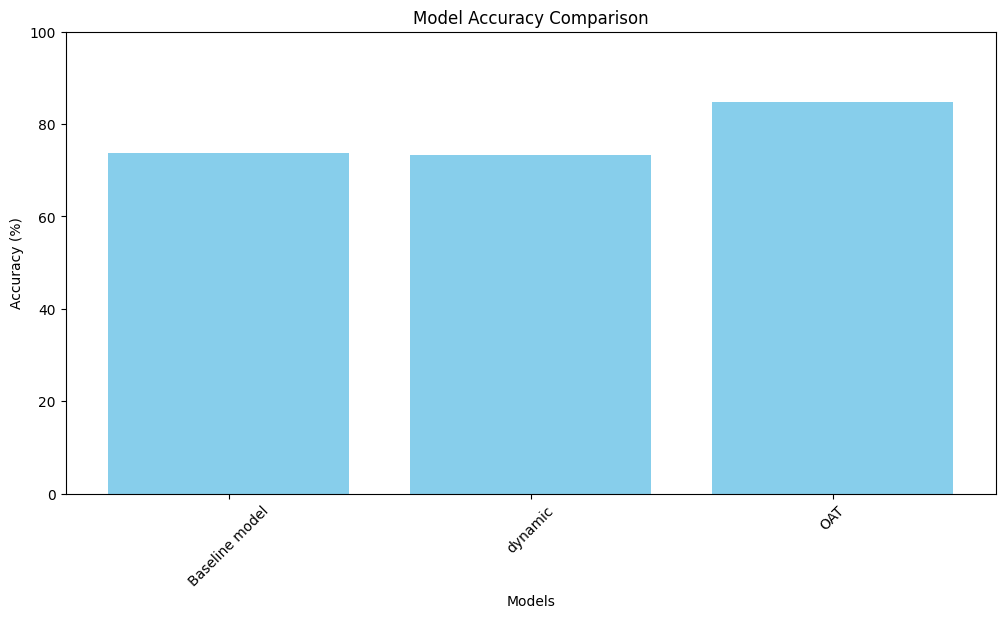

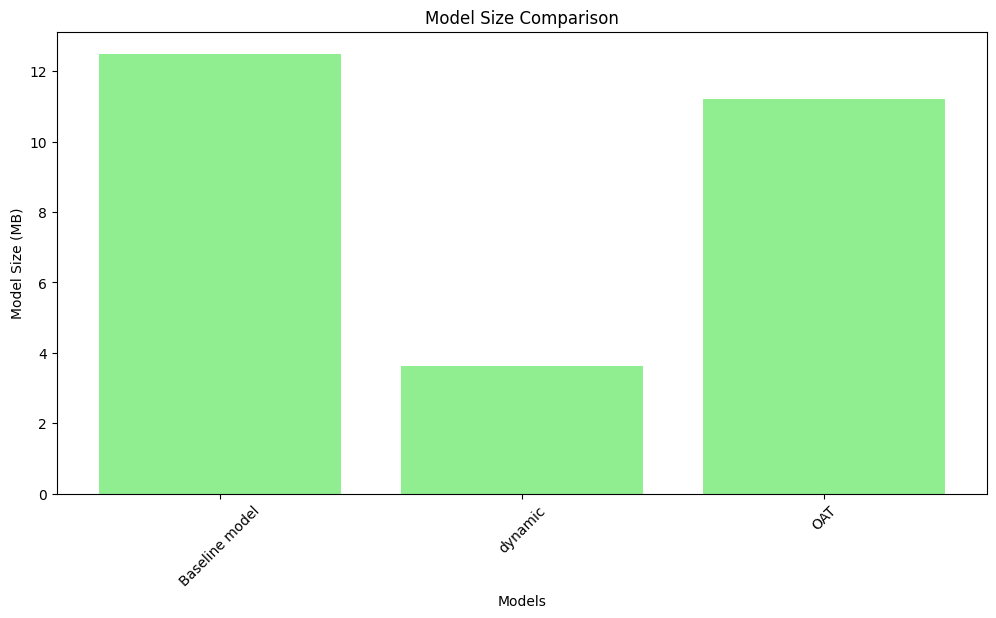

In [154]:
import matplotlib.pyplot as plt

# Data
models = ['Baseline model','dynamic','OAT']
accuracy = [73.78, 73.30,84.81]
model_size = [12.5,3.63,11.2]

# Plotting the first bar graph (Accuracy)
plt.figure(figsize=(12, 6))
plt.bar(models, accuracy, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Assuming accuracy is a percentage, set y-axis limit from 0 to 100
plt.show()

# Plotting the second bar graph (Model Size)
plt.figure(figsize=(12, 6))
plt.bar(models, model_size, color='lightgreen')
plt.xlabel('Models')
plt.ylabel('Model Size (MB)')
plt.title('Model Size Comparison')
plt.xticks(rotation=45)
plt.show()

In [17]:
labels

{0: 'Adho Mukha Svanasana',
 1: 'Adho Mukha Vrksasana',
 2: 'Alanasana',
 3: 'Anjaneyasana',
 4: 'Ardha Chandrasana',
 5: 'Ardha Matsyendrasana',
 6: 'Ardha Navasana',
 7: 'Ardha Pincha Mayurasana',
 8: 'Ashta Chandrasana',
 9: 'Baddha Konasana',
 10: 'Bakasana',
 11: 'Balasana',
 12: 'Bitilasana',
 13: 'Camatkarasana',
 14: 'Dhanurasana',
 15: 'Eka Pada Rajakapotasana',
 16: 'Garudasana',
 17: 'Halasana',
 18: 'Hanumanasana',
 19: 'Malasana',
 20: 'Marjaryasana',
 21: 'Padmasana',
 22: 'Parsvottanasana',
 23: 'Paschimottanasana',
 24: 'Phalakasana',
 25: 'Pincha Mayurasana',
 26: 'Salamba Bhujangasana',
 27: 'Salamba Sarvangasana',
 28: 'Setu Bandha Sarvangasana',
 29: 'Sivasana',
 30: 'Supta Kapotasana',
 31: 'Urdhva Dhanurasana',
 32: 'Urdhva Mukha Svsnssana',
 33: 'Ustrasana',
 34: 'Utkatasana',
 35: 'Uttanasana',
 36: 'Utthita Hasta Padangusthasana',
 37: 'Utthita Parsvakonasana',
 38: 'Vasisthasana',
 39: 'Virabhadrasana One',
 40: 'Virabhadrasana Three',
 41: 'Virabhadrasana Two

In [16]:
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

In [ ]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

NameError: name 'pred' is not defined

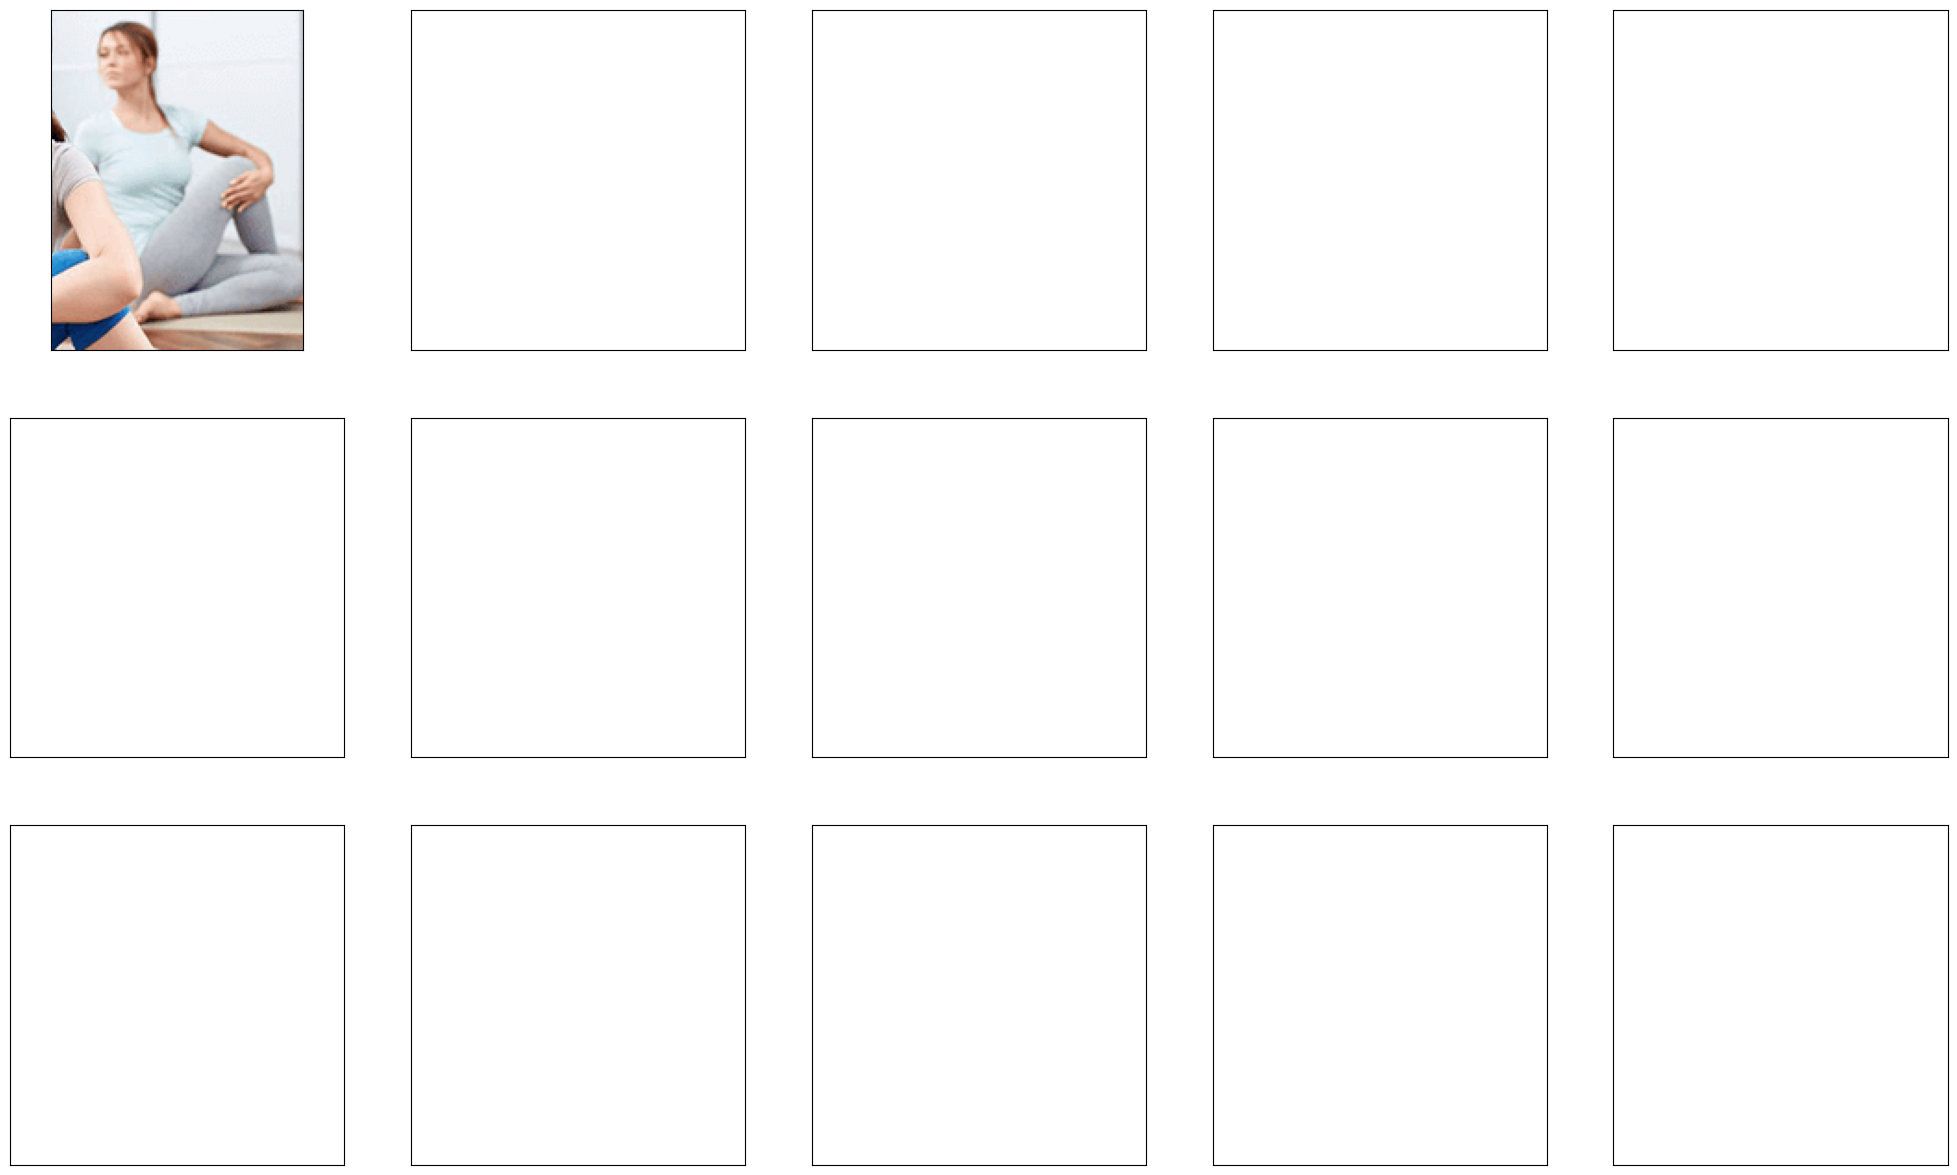

In [19]:
 # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

The first 5 predictions: ['Utkatasana', 'Utkatasana', 'Padmasana', 'Utkatasana', 'Utkatasana']


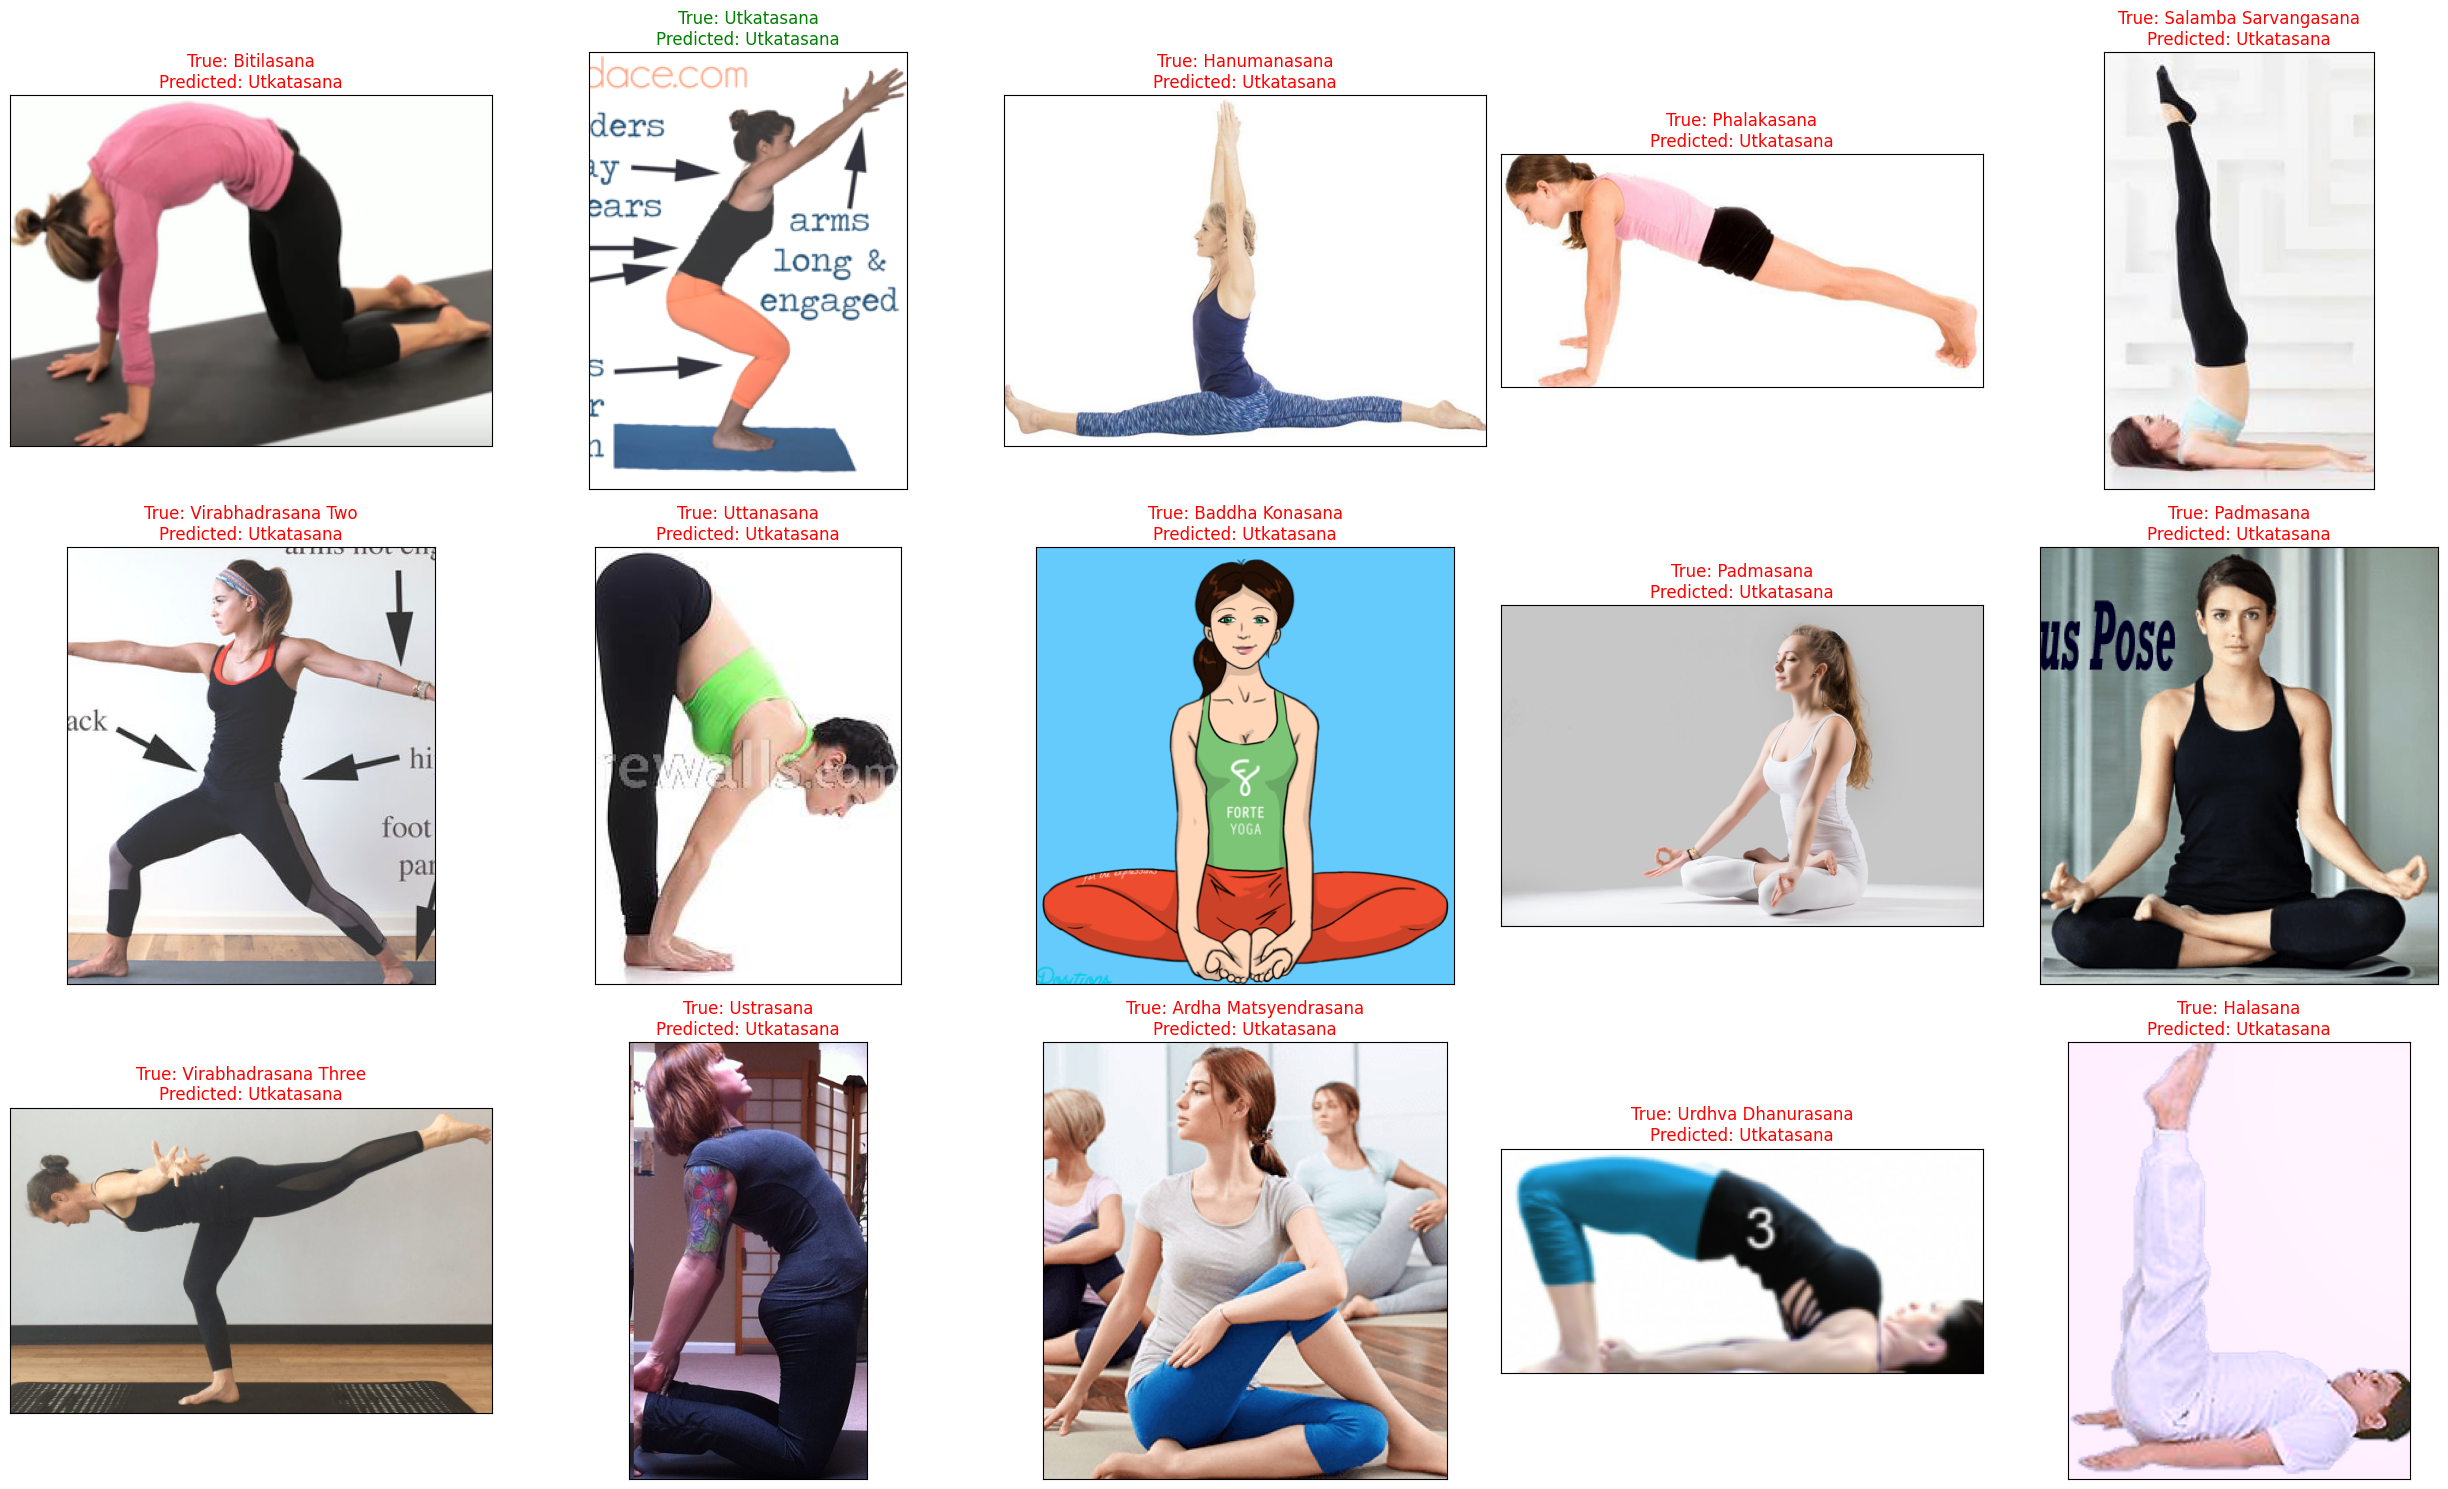

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the TFLite model
model_path = 'Tflite\dynamic_quant_model.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image
def preprocess_image(image_path, target_size):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image from path: {image_path}")
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict using the TFLite model
def predict_tflite(image_path):
    input_image = preprocess_image(image_path, target_size=(224, 224))  # Assuming model input size is 224x224
    interpreter.set_tensor(input_details[0]['index'], input_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output)
    return predicted_class



# Load test images and their true labels (assuming you have test_df DataFrame)
# test_df should contain columns: 'Filepath' and 'Label'

# Predict the label of the test_images
test_images = test_df['Filepath'].values
pred = [predict_tflite(image_path) for image_path in test_images]
pred_labels = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred_labels[:5]}')

# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image_path = test_df.Filepath.iloc[random_index[i]]
    true_label = test_df.Label.iloc[random_index[i]]
    predicted_label = pred_labels[random_index[i]]
    
    ax.imshow(plt.imread(image_path))
    color = "green" if true_label == predicted_label else "red"
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}", color=color)

plt.tight_layout()
plt.show()


# 📊Plotting the classification reports and confusion matrix

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

# ☀️Grad-Cam Visualization

**Source code inspiration can be found [here](https://www.kaggle.com/code/databeru/visual-explanations-from-deep-networks-grad-cam)**

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

***

## 👋Thanks for visting my notebook
<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; background-color:purple; color:white">
    📌 I would greatly appreciate any feedback, suggestions and recommendations for improvement. Cheers! 😊
</div>

<center><img src='https://media4.giphy.com/media/M9gbBd9nbDrOTu1Mqx/giphy.gif?cid=790b7611704aa2ca4e403287801480a6c753abf45f3e6242&rid=giphy.gif&ct=s' 
     height=30px width=160px /></center>

In [21]:
labels

{0: 'Adho Mukha Svanasana',
 1: 'Adho Mukha Vrksasana',
 2: 'Alanasana',
 3: 'Anjaneyasana',
 4: 'Ardha Chandrasana',
 5: 'Ardha Matsyendrasana',
 6: 'Ardha Navasana',
 7: 'Ardha Pincha Mayurasana',
 8: 'Ashta Chandrasana',
 9: 'Baddha Konasana',
 10: 'Bakasana',
 11: 'Balasana',
 12: 'Bitilasana',
 13: 'Camatkarasana',
 14: 'Dhanurasana',
 15: 'Eka Pada Rajakapotasana',
 16: 'Garudasana',
 17: 'Halasana',
 18: 'Hanumanasana',
 19: 'Malasana',
 20: 'Marjaryasana',
 21: 'Padmasana',
 22: 'Parsvottanasana',
 23: 'Paschimottanasana',
 24: 'Phalakasana',
 25: 'Pincha Mayurasana',
 26: 'Salamba Bhujangasana',
 27: 'Salamba Sarvangasana',
 28: 'Setu Bandha Sarvangasana',
 29: 'Sivasana',
 30: 'Supta Kapotasana',
 31: 'Urdhva Dhanurasana',
 32: 'Urdhva Mukha Svsnssana',
 33: 'Ustrasana',
 34: 'Utkatasana',
 35: 'Uttanasana',
 36: 'Utthita Hasta Padangusthasana',
 37: 'Utthita Parsvakonasana',
 38: 'Vasisthasana',
 39: 'Virabhadrasana One',
 40: 'Virabhadrasana Three',
 41: 'Virabhadrasana Two

In [58]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the labels
# labels = ['Adho Mukha Svanasana', 'Adho Mukha Vrikshasana', ...]  # Replace with your actual label list

# Load the quantized model
interpreter = tf.lite.Interpreter(model_path='D:/6th sem/Minor 2/Baseline model/Post/dynamic_quant_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Convert to RGB mode
    img = img.resize((224, 224))
    img = np.array(img)
    img = img / 255.0
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)
    return img

# Function to predict the yoga pose
def predict_pose(image_path):
    # Preprocess the image
    input_data = preprocess_image(image_path)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Get the predicted class index
    predicted_class_index = np.argmax(output_data)

    # Return the predicted label
    return labels[predicted_class_index]

# Test the model with a sample image
image_path = "D:/6th sem/Minor 2/Orginal/Poses/Ardha Chandrasana/File1.png"  # Replace with the path to your test image
predicted_label = predict_pose(image_path)
print("Predicted yoga pose:", predicted_label)

Predicted yoga pose: Dhanurasana


In [50]:
img = Image.open(image_path).convert('RGB')  # Convert to RGB mode

In [60]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the labels
# labels = ['Adho Mukha Svanasana', 'Adho Mukha Vrikshasana', ...]  # Replace with your actual label list

# Load the quantized model
interpreter = tf.lite.Interpreter(model_path='D:/6th sem/Minor 2/Baseline model/Post/dynamic_quant_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image
# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Convert to RGB mode
    img = img.resize((224, 224))
    img = np.array(img, dtype=np.float32)  # Convert to float32
    img = img / 255.0  # Normalize pixel values to [0, 1]
    img = np.expand_dims(img, axis=0)
    return img

# Function to predict the yoga pose
def predict_pose(image_path):
    # Preprocess the image
    input_data = preprocess_image(image_path)

    # Print the shape and content of the input tensor
    print("Input Shape:", input_data.shape)
    print("Input Content:", input_data)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Print the shape and content of the output tensor
    print("Output Shape:", output_data.shape)
    print("Output Content:", output_data)

    # Get the predicted class index
    predicted_class_index = np.argmax(output_data)

    # Return the predicted label
    return labels[predicted_class_index]

# Test the model with a sample image
image_path = "D:/6th sem/Minor 2/Orginal/Poses/Adho Mukha Svanasana/File1.png"  # Replace with the path to your test image
predicted_label = predict_pose(image_path)
print("Predicted yoga pose:", predicted_label)

Input Shape: (1, 224, 224, 3)
Input Content: [[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]]
Output Shape: (1, 43)
Output Content: [[0.02915638 0.0101129  0.00749792 0.05160756 0.012934   0.01723582
  0.00803912 0.00617293 0.0042012  0.02088139 0.02574172 0.08407009
  0.02779431 0.00761593 0.11321502 0.01989244 0.01499531 0.02720485
  0.01916513 0.015416   0.01382439 0.05208717 0.03211953 0.03839187
  0.01056578 0.00753505 0.02668228 0.01361915 0.02076285 0.00972559
  0.0095001

In [62]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the labels
# labels = ['Adho Mukha Svanasana', 'Adho Mukha Vrikshasana', 'Akarna Dhanurasana', 'Ananda Balasana', 'Anantasana', 'Anjaneyasana', 'Ardha Bhekasana', 'Ardha Chandrasana', 'Ardha Matsyendrasana', 'Ardha Pincha Mayurasana', 'Ardha Uttanasana', 'Ashtanga Namaskara', 'Astavakrasana', 'Baddha Konasana', 'Bakasana', 'Balasana', 'Bhairavasana', 'Bharadvajasana', 'Bhekasana', 'Bhujangasana', 'Bhujapidasana', 'Bitilasana', 'Camatkarasana', 'Chakravakasana', 'Chaturanga Dandasana', 'Dandasana', 'Dhanurasana', 'Durvasasana', 'Dwi Pada Viparita Dandasana', 'Eka Hasta Bhujasana', 'Eka Pada Koundinyanasana', 'Eka Pada Rajakapotasana', 'Ganda Bherundasana', 'Garbha Pindasana', 'Garudasana', 'Gomukhasana', 'Hanumanasana', 'Kapotasana', 'Makarasana', 'Malasana', 'Marichyasana', 'Matsyasana', 'Mayurasana', 'Natarajasana', 'Padahastasana', 'Padmasana', 'Parivrtta Janu Sirsasana', 'Parivrtta Trikonasana', 'Parsva Bakasana', 'Parsvottanasana', 'Pasasana', 'Phalakasana', 'Pincha Mayurasana', 'Prasarita Padottanasana', 'Pupasana', 'Rajakapotasana', 'Salabhasana', 'Salamba Bhujangasana', 'Salamba Sarvangasana', 'Salamba Sirsasana', 'Savasana', 'Setu Bandha Sarvangasana', 'Simhasana', 'Supta Baddha Konasana', 'Supta Padangushthasana', 'Supta Virasana', 'Tadasana', 'Tittibhasana', 'Tolasana', 'Urdhva Dhanurasana', 'Urdhva Hastasana', 'Urdhva Mukha Svanasana', 'Ushtrasana', 'Ustrasana', 'Utkatasana', 'Utthita Hasta Padangushthasana', 'Utthita Parsvakonasana', 'Utthita Trikonasana', 'Vasisthasana', 'Viparita Karani', 'Virabhadrasana', 'Virasana', 'Vrikshasana', 'Yoganidrasana']

# Load the quantized model
interpreter = tf.lite.Interpreter(model_path='D:/6th sem/Minor 2/Baseline model/Post/dynamic_quant_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Convert to RGB mode
    img = img.resize((224, 224))
    img = np.array(img, dtype=np.float32)  # Convert to float32
    img = tf.keras.applications.mobilenet_v3.preprocess_input(img)  # Preprocess using MobileNetV3 preprocessing function
    img = np.expand_dims(img, axis=0)
    return img


# def preprocess_image(image_path):
#     img = Image.open(image_path).convert('RGB')  # Convert to RGB mode
#     img = img.resize((224, 224))
#     img = np.array(img, dtype=np.float32)  # Convert to float32
#     img = img / 255.0  # Normalize pixel values to [0, 1]
#     img = np.expand_dims(img, axis=0)
#     return img

# Function to predict the yoga pose
def predict_pose(image_path):
    # Preprocess the image
    input_data = preprocess_image(image_path)

    # Print the shape and content of the input tensor
    print("Input Shape:", input_data.shape)
    print("Input Content:", input_data)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Print the shape and content of the output tensor
    print("Output Shape:", output_data.shape)
    print("Output Content:", output_data)

    # Get the predicted class index
    predicted_class_index = np.argmax(output_data)

    # Return the predicted label
    return labels[predicted_class_index]

# Test the model with a sample image
image_path = "D:/6th sem/Minor 2/Orginal/Poses/Bitilasana/File1.png"  # Replace with the path to your test image
predicted_label = predict_pose(image_path)
print("Predicted yoga pose:", predicted_label)

Input Shape: (1, 224, 224, 3)
Input Content: [[[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  ...

  [[239. 254. 255.]
   [239. 254. 255.]
   [241. 253. 255.]
   ...
   [236. 237. 237.]
   [233. 252. 255.]
   [233. 251. 255.]]

  [[241. 253. 254.]
   [241. 254. 254.]
   [240. 254. 254.]
   ...
   [238. 247. 252.]
   [231. 248. 255.]
   [231. 248. 254.]]

  [[239. 255. 255.]
   [238. 255. 255.]
   [237. 255. 255.]
   ...
   [236. 247. 253.]
   [235. 250. 254.]
   [235. 250. 254.]]]]
Output Shape: (1, 43)
Output Content: [[8.26106698e-04 2.27300823e-03 3.10606381e-04 1.61367767e-02
  5.43168001e-03 1.18086655e-02 1.59942370e-04 1.04604498e-03
  6.2520572

In [18]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the labels
# labels = ['Adho Mukha Svanasana', 'Adho Mukha Vrikshasana', 'Akarna Dhanurasana', 'Ananda Balasana', 'Anantasana', 'Anjaneyasana', 'Ardha Bhekasana', 'Ardha Chandrasana', 'Ardha Matsyendrasana', 'Ardha Pincha Mayurasana', 'Ardha Uttanasana', 'Ashtanga Namaskara', 'Astavakrasana', 'Baddha Konasana', 'Bakasana', 'Balasana', 'Bhairavasana', 'Bharadvajasana', 'Bhekasana', 'Bhujangasana', 'Bhujapidasana', 'Bitilasana', 'Camatkarasana', 'Chakravakasana', 'Chaturanga Dandasana', 'Dandasana', 'Dhanurasana', 'Durvasasana', 'Dwi Pada Viparita Dandasana', 'Eka Hasta Bhujasana', 'Eka Pada Koundinyanasana', 'Eka Pada Rajakapotasana', 'Ganda Bherundasana', 'Garbha Pindasana', 'Garudasana', 'Gomukhasana', 'Hanumanasana', 'Kapotasana', 'Makarasana', 'Malasana', 'Marichyasana', 'Matsyasana', 'Mayurasana', 'Natarajasana', 'Padahastasana', 'Padmasana', 'Parivrtta Janu Sirsasana', 'Parivrtta Trikonasana', 'Parsva Bakasana', 'Parsvottanasana', 'Pasasana', 'Phalakasana', 'Pincha Mayurasana', 'Prasarita Padottanasana', 'Pupasana', 'Rajakapotasana', 'Salabhasana', 'Salamba Bhujangasana', 'Salamba Sarvangasana', 'Salamba Sirsasana', 'Savasana', 'Setu Bandha Sarvangasana', 'Simhasana', 'Supta Baddha Konasana', 'Supta Padangushthasana', 'Supta Virasana', 'Tadasana', 'Tittibhasana', 'Tolasana', 'Urdhva Dhanurasana', 'Urdhva Hastasana', 'Urdhva Mukha Svanasana', 'Ushtrasana', 'Ustrasana', 'Utkatasana', 'Utthita Hasta Padangushthasana', 'Utthita Parsvakonasana', 'Utthita Trikonasana', 'Vasisthasana', 'Viparita Karani', 'Virabhadrasana', 'Virasana', 'Vrikshasana', 'Yoganidrasana']

# Load the quantized model
interpreter = tf.lite.Interpreter(model_path='D:/6th sem/Minor 2/Baseline model/Post/dynamic_quant_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Convert to RGB mode
    img = img.resize((224, 224))
    img = np.array(img, dtype=np.float32)  # Convert to float32
    img = tf.keras.applications.mobilenet_v3.preprocess_input(img)  # Preprocess using MobileNetV3 preprocessing function
    img = np.expand_dims(img, axis=0)
    return img

# Function to predict the yoga pose
def predict_pose(image_path):
    # Preprocess the image
    input_data = preprocess_image(image_path)

    # Print the shape and content of the input tensor
    print("Input Shape:", input_data.shape)
    print("Input Content:", input_data)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Print the shape and content of the output tensor
    print("Output Shape:", output_data.shape)
    print("Output Content:", output_data)

    # Get the predicted class index
    predicted_class_index = np.argmax(output_data)

    # Return the predicted label
    return labels[predicted_class_index]

# Test the model with a sample image
image_path = "D:/6th sem/Minor 2/Orginal/Poses/Hanumanasana/File23.png"  # Replace with the path to your test image
predicted_label = predict_pose(image_path)
print("Predicted yoga pose:", predicted_label)

Input Shape: (1, 224, 224, 3)
Input Content: [[[[236. 236. 236.]
   [236. 236. 236.]
   [237. 237. 237.]
   ...
   [216. 216. 216.]
   [215. 215. 215.]
   [215. 215. 215.]]

  [[236. 236. 236.]
   [236. 236. 236.]
   [237. 237. 237.]
   ...
   [216. 216. 216.]
   [215. 215. 215.]
   [215. 215. 215.]]

  [[237. 237. 237.]
   [237. 237. 237.]
   [237. 237. 237.]
   ...
   [215. 215. 215.]
   [216. 216. 216.]
   [216. 216. 216.]]

  ...

  [[107. 107. 107.]
   [108. 108. 108.]
   [108. 108. 108.]
   ...
   [ 41.  41.  41.]
   [ 28.  28.  28.]
   [ 48.  48.  48.]]

  [[112. 112. 112.]
   [112. 112. 112.]
   [113. 113. 113.]
   ...
   [ 90.  90.  90.]
   [ 49.  49.  49.]
   [ 48.  48.  48.]]

  [[108. 108. 108.]
   [109. 109. 109.]
   [110. 110. 110.]
   ...
   [173. 173. 173.]
   [175. 175. 175.]
   [174. 174. 174.]]]]
Output Shape: (1, 43)
Output Content: [[6.97813090e-03 8.74767546e-03 2.41914895e-04 1.17764227e-01
  9.60793253e-03 2.47460528e-04 1.47826620e-03 8.51903867e-04
  1.0235222

In [68]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the labels
# labels = ['Adho Mukha Svanasana', 'Adho Mukha Vrikshasana', 'Akarna Dhanurasana', 'Ananda Balasana', 'Anantasana', 'Anjaneyasana', 'Ardha Bhekasana', 'Ardha Chandrasana', 'Ardha Matsyendrasana', 'Ardha Pincha Mayurasana', 'Ardha Uttanasana', 'Ashtanga Namaskara', 'Astavakrasana', 'Baddha Konasana', 'Bakasana', 'Balasana', 'Bhairavasana', 'Bharadvajasana', 'Bhekasana', 'Bhujangasana', 'Bhujapidasana', 'Bitilasana', 'Camatkarasana', 'Chakravakasana', 'Chaturanga Dandasana', 'Dandasana', 'Dhanurasana', 'Durvasasana', 'Dwi Pada Viparita Dandasana', 'Eka Hasta Bhujasana', 'Eka Pada Koundinyanasana', 'Eka Pada Rajakapotasana', 'Ganda Bherundasana', 'Garbha Pindasana', 'Garudasana', 'Gomukhasana', 'Hanumanasana', 'Kapotasana', 'Makarasana', 'Malasana', 'Marichyasana', 'Matsyasana', 'Mayurasana', 'Natarajasana', 'Padahastasana', 'Padmasana', 'Parivrtta Janu Sirsasana', 'Parivrtta Trikonasana', 'Parsva Bakasana', 'Parsvottanasana', 'Pasasana', 'Phalakasana', 'Pincha Mayurasana', 'Prasarita Padottanasana', 'Pupasana', 'Rajakapotasana', 'Salabhasana', 'Salamba Bhujangasana', 'Salamba Sarvangasana', 'Salamba Sirsasana', 'Savasana', 'Setu Bandha Sarvangasana', 'Simhasana', 'Supta Baddha Konasana', 'Supta Padangushthasana', 'Supta Virasana', 'Tadasana', 'Tittibhasana', 'Tolasana', 'Urdhva Dhanurasana', 'Urdhva Hastasana', 'Urdhva Mukha Svanasana', 'Ushtrasana', 'Ustrasana', 'Utkatasana', 'Utthita Hasta Padangushthasana', 'Utthita Parsvakonasana', 'Utthita Trikonasana', 'Vasisthasana', 'Viparita Karani', 'Virabhadrasana', 'Virasana', 'Vrikshasana', 'Yoganidrasana']

# Load the quantized model
interpreter = tf.lite.Interpreter(model_path='D:/6th sem/Minor 2/Baseline model/Post/dynamic_quant_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Convert to RGB mode
    img = img.resize((224, 224))
    img = np.array(img, dtype=np.float32)  # Convert to float32
    img = tf.keras.applications.mobilenet_v3.preprocess_input(img)  # Preprocess using MobileNetV3 preprocessing function
    img = np.expand_dims(img, axis=0)
    return img

# Function to predict the yoga pose
def predict_pose(image_path):
    # Preprocess the image
    input_data = preprocess_image(image_path)

    # Print the shape and content of the input tensor
    print("Input Shape:", input_data.shape)
    print("Input Content:", input_data)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Print the shape and content of the output tensor
    print("Output Shape:", output_data.shape)
    print("Output Content:", output_data)

    # Get the predicted class index
    predicted_class_index = np.argmax(output_data)

    # Return the predicted label
    return labels[predicted_class_index]

# Test the model with a sample image
image_path ="D:/6th sem/Minor 2/Orginal/Poses/Camatkarasana/File13.png"  # Replace with the path to your test image
predicted_label = predict_pose(image_path)
print("Predicted yoga pose:", predicted_label)

Input Shape: (1, 224, 224, 3)
Input Content: [[[[204. 204. 204.]
   [204. 204. 204.]
   [204. 204. 204.]
   ...
   [204. 204. 204.]
   [204. 204. 204.]
   [204. 204. 204.]]

  [[204. 204. 204.]
   [204. 204. 204.]
   [204. 204. 204.]
   ...
   [204. 204. 204.]
   [204. 204. 204.]
   [204. 204. 204.]]

  [[204. 204. 204.]
   [204. 204. 204.]
   [204. 204. 204.]
   ...
   [204. 204. 204.]
   [204. 204. 204.]
   [204. 204. 204.]]

  ...

  [[249. 249. 249.]
   [250. 250. 250.]
   [250. 250. 250.]
   ...
   [ 81.  75.  72.]
   [ 78.  72.  69.]
   [ 81.  75.  72.]]

  [[250. 250. 250.]
   [250. 250. 250.]
   [250. 250. 250.]
   ...
   [ 91.  86.  83.]
   [ 89.  85.  82.]
   [ 93.  88.  85.]]

  [[250. 250. 250.]
   [250. 250. 250.]
   [250. 250. 250.]
   ...
   [ 93.  88.  85.]
   [ 92.  87.  84.]
   [ 92.  87.  84.]]]]
Output Shape: (1, 43)
Output Content: [[5.84635064e-02 4.44100355e-04 3.72024544e-04 3.38609330e-03
  3.76902148e-02 5.65076200e-03 3.65782267e-04 1.71246137e-02
  1.1596578

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11860\1487150328.py:41: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax1.legend(bars, labels, loc='upper left')


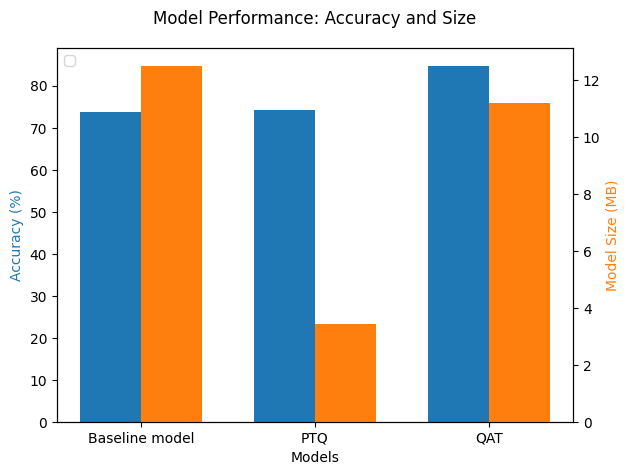

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Baseline model', 'PTQ', 'QAT']
accuracy = [73.78, 74.30, 84.71]
model_size = [12.5, 3.43, 11.2]

# Create figure and axis objects
fig, ax1 = plt.subplots()

# Set bar width
bar_width = 0.35

# Set positions of the bars
index = np.arange(len(models))

# Plot accuracy bars
bar1 = ax1.bar(index, accuracy, bar_width, label='Accuracy (%)', color='tab:blue')

# Create secondary y-axis for model size
ax2 = ax1.twinx()

# Plot model size bars
bar2 = ax2.bar(index + bar_width, model_size, bar_width, label='Model Size (MB)', color='tab:orange')

# Add labels, title and set tick positions
ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy (%)', color='tab:blue')
ax2.set_ylabel('Model Size (MB)', color='tab:orange')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(models)

# Title and layout adjustments
fig.suptitle('Model Performance: Accuracy and Size')
fig.tight_layout()

# Add legends
bars = bar1 + bar2
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc='upper left')

# Show plot
plt.show()


In [23]:
import tensorflow as tf
import numpy as np
from PIL import Image
import time  # Import the time module

# Load the labels
# labels = ["label1", "label2", "label3"]  # Replace with your actual labels

# Load the quantized model
interpreter = tf.lite.Interpreter(model_path='Tflite\dynamic_quant_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Convert to RGB mode
    img = img.resize((224, 224))
    img = np.array(img, dtype=np.float32)  # Convert to float32
    img = tf.keras.applications.mobilenet_v3.preprocess_input(img)  # Preprocess using MobileNetV3 preprocessing function
    img = np.expand_dims(img, axis=0)
    return img

# Function to predict the yoga pose
def predict_pose(image_path):
    # Preprocess the image
    input_data = preprocess_image(image_path)

    # Print the shape and content of the input tensor
    print("Input Shape:", input_data.shape)
    print("Input Content:", input_data)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Measure the inference time
    start_time = time.time()
    interpreter.invoke()
    end_time = time.time()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Print the shape and content of the output tensor
    print("Output Shape:", output_data.shape)
    print("Output Content:", output_data)

    # Get the predicted class index
    predicted_class_index = np.argmax(output_data)

    # Calculate and print the inference time
    inference_time = end_time - start_time
    print("Inference Time:", inference_time)

    # Return the predicted label and inference time
    return labels[predicted_class_index], inference_time

# Test the model with a sample image
image_path = "D:/6th sem/Minor 2/Orginal/Poses/Hanumanasana/File23.png"  # Replace with the path to your test image
predicted_label, inference_time = predict_pose(image_path)
print("Predicted yoga pose:", predicted_label)
print("Inference time:", inference_time)


Input Shape: (1, 224, 224, 3)
Input Content: [[[[236. 236. 236.]
   [236. 236. 236.]
   [237. 237. 237.]
   ...
   [216. 216. 216.]
   [215. 215. 215.]
   [215. 215. 215.]]

  [[236. 236. 236.]
   [236. 236. 236.]
   [237. 237. 237.]
   ...
   [216. 216. 216.]
   [215. 215. 215.]
   [215. 215. 215.]]

  [[237. 237. 237.]
   [237. 237. 237.]
   [237. 237. 237.]
   ...
   [215. 215. 215.]
   [216. 216. 216.]
   [216. 216. 216.]]

  ...

  [[107. 107. 107.]
   [108. 108. 108.]
   [108. 108. 108.]
   ...
   [ 41.  41.  41.]
   [ 28.  28.  28.]
   [ 48.  48.  48.]]

  [[112. 112. 112.]
   [112. 112. 112.]
   [113. 113. 113.]
   ...
   [ 90.  90.  90.]
   [ 49.  49.  49.]
   [ 48.  48.  48.]]

  [[108. 108. 108.]
   [109. 109. 109.]
   [110. 110. 110.]
   ...
   [173. 173. 173.]
   [175. 175. 175.]
   [174. 174. 174.]]]]
Output Shape: (1, 43)
Output Content: [[8.4282568e-04 4.1355372e-05 3.6968390e-04 7.8206539e-02 1.5356764e-03
  6.1595470e-05 8.7730696e-05 1.9184772e-03 3.0536230e-05 2.975

In [20]:
import tensorflow as tf
import numpy as np
from PIL import Image
import time  # Import the time module

# Load the labels
# labels = ["label1", "label2", "label3"]  # Replace with your actual labels

# Load the quantized model
interpreter = tf.lite.Interpreter(model_path='Tflite\yoga_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Convert to RGB mode
    img = img.resize((224, 224))
    img = np.array(img, dtype=np.float32)  # Convert to float32
    img = tf.keras.applications.mobilenet_v3.preprocess_input(img)  # Preprocess using MobileNetV3 preprocessing function
    img = np.expand_dims(img, axis=0)
    return img

# Function to predict the yoga pose
def predict_pose(image_path):
    # Preprocess the image
    input_data = preprocess_image(image_path)

    # Print the shape and content of the input tensor
    print("Input Shape:", input_data.shape)
    print("Input Content:", input_data)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Measure the inference time
    start_time = time.time()
    interpreter.invoke()
    end_time = time.time()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Print the shape and content of the output tensor
    print("Output Shape:", output_data.shape)
    print("Output Content:", output_data)

    # Get the predicted class index
    predicted_class_index = np.argmax(output_data)

    # Calculate and print the inference time
    inference_time = end_time - start_time
    print("Inference Time:", inference_time)

    # Return the predicted label and inference time
    return labels[predicted_class_index], inference_time

# Test the model with a sample image
image_path = "D:/6th sem/Minor 2/Orginal/Poses/Hanumanasana/File23.png"  # Replace with the path to your test image
predicted_label, inference_time = predict_pose(image_path)
print("Predicted yoga pose:", predicted_label)
print("Inference time:", inference_time)


Input Shape: (1, 224, 224, 3)
Input Content: [[[[236. 236. 236.]
   [236. 236. 236.]
   [237. 237. 237.]
   ...
   [216. 216. 216.]
   [215. 215. 215.]
   [215. 215. 215.]]

  [[236. 236. 236.]
   [236. 236. 236.]
   [237. 237. 237.]
   ...
   [216. 216. 216.]
   [215. 215. 215.]
   [215. 215. 215.]]

  [[237. 237. 237.]
   [237. 237. 237.]
   [237. 237. 237.]
   ...
   [215. 215. 215.]
   [216. 216. 216.]
   [216. 216. 216.]]

  ...

  [[107. 107. 107.]
   [108. 108. 108.]
   [108. 108. 108.]
   ...
   [ 41.  41.  41.]
   [ 28.  28.  28.]
   [ 48.  48.  48.]]

  [[112. 112. 112.]
   [112. 112. 112.]
   [113. 113. 113.]
   ...
   [ 90.  90.  90.]
   [ 49.  49.  49.]
   [ 48.  48.  48.]]

  [[108. 108. 108.]
   [109. 109. 109.]
   [110. 110. 110.]
   ...
   [173. 173. 173.]
   [175. 175. 175.]
   [174. 174. 174.]]]]
Output Shape: (1, 43)
Output Content: [[6.2029227e-03 1.0481526e-02 2.4079949e-04 1.0107674e-01 1.3192378e-02
  1.7507872e-04 1.5992163e-03 1.1880532e-03 1.0593672e-03 5.035

In [21]:
import tensorflow as tf
import numpy as np
from PIL import Image
import time  # Import the time module

# Load the labels
# labels = ["label1", "label2", "label3"]  # Replace with your actual labels

# Load the quantized model
interpreter = tf.lite.Interpreter(model_path='Tflite\QAT_dynamic_quant_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Convert to RGB mode
    img = img.resize((224, 224))
    img = np.array(img, dtype=np.float32)  # Convert to float32
    img = tf.keras.applications.mobilenet_v3.preprocess_input(img)  # Preprocess using MobileNetV3 preprocessing function
    img = np.expand_dims(img, axis=0)
    return img

# Function to predict the yoga pose
def predict_pose(image_path):
    # Preprocess the image
    input_data = preprocess_image(image_path)

    # Print the shape and content of the input tensor
    print("Input Shape:", input_data.shape)
    print("Input Content:", input_data)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Measure the inference time
    start_time = time.time()
    interpreter.invoke()
    end_time = time.time()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Print the shape and content of the output tensor
    print("Output Shape:", output_data.shape)
    print("Output Content:", output_data)

    # Get the predicted class index
    predicted_class_index = np.argmax(output_data)

    # Calculate and print the inference time
    inference_time = end_time - start_time
    print("Inference Time:", inference_time)

    # Return the predicted label and inference time
    return labels[predicted_class_index], inference_time

# Test the model with a sample image
image_path = "D:/6th sem/Minor 2/Orginal/Poses/Hanumanasana/File23.png"  # Replace with the path to your test image
predicted_label, inference_time = predict_pose(image_path)
print("Predicted yoga pose:", predicted_label)
print("Inference time:", inference_time)


Input Shape: (1, 224, 224, 3)
Input Content: [[[[236. 236. 236.]
   [236. 236. 236.]
   [237. 237. 237.]
   ...
   [216. 216. 216.]
   [215. 215. 215.]
   [215. 215. 215.]]

  [[236. 236. 236.]
   [236. 236. 236.]
   [237. 237. 237.]
   ...
   [216. 216. 216.]
   [215. 215. 215.]
   [215. 215. 215.]]

  [[237. 237. 237.]
   [237. 237. 237.]
   [237. 237. 237.]
   ...
   [215. 215. 215.]
   [216. 216. 216.]
   [216. 216. 216.]]

  ...

  [[107. 107. 107.]
   [108. 108. 108.]
   [108. 108. 108.]
   ...
   [ 41.  41.  41.]
   [ 28.  28.  28.]
   [ 48.  48.  48.]]

  [[112. 112. 112.]
   [112. 112. 112.]
   [113. 113. 113.]
   ...
   [ 90.  90.  90.]
   [ 49.  49.  49.]
   [ 48.  48.  48.]]

  [[108. 108. 108.]
   [109. 109. 109.]
   [110. 110. 110.]
   ...
   [173. 173. 173.]
   [175. 175. 175.]
   [174. 174. 174.]]]]
Output Shape: (1, 43)
Output Content: [[0.         0.00390625 0.         0.0078125  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.

In [25]:
import tensorflow as tf
import numpy as np
from PIL import Image
import time

# Load the labels
# labels = ["Hanumanasana", "label2", "label3"]  # Replace with your actual labels

# Load the model
interpreter = tf.lite.Interpreter(model_path='Tflite\dynamic_quant_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Convert to RGB mode
    img = img.resize((224, 224))
    img = np.array(img, dtype=np.float32)  # Convert to float32
    img = tf.keras.applications.mobilenet_v3.preprocess_input(img)  # Preprocess using MobileNetV3 preprocessing function
    img = np.expand_dims(img, axis=0)
    return img

# Function to predict the yoga pose
def predict_pose(image_path, num_runs=10):
    # Preprocess the image
    input_data = preprocess_image(image_path)

    # Print the shape and content of the input tensor
    print("Input Shape:", input_data.shape)
    print("Input Content:", input_data)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Measure the inference time over multiple runs
    total_time = 0
    for _ in range(num_runs):
        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()
        total_time += end_time - start_time

    average_inference_time = total_time / num_runs

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Print the shape and content of the output tensor
    print("Output Shape:", output_data.shape)
    print("Output Content:", output_data)

    # Get the predicted class index
    predicted_class_index = np.argmax(output_data)

    # Calculate and print the average inference time
    print("Average Inference Time:", average_inference_time)

    # Return the predicted label and average inference time
    return labels[predicted_class_index], average_inference_time

# Test the model with a sample image
image_path = "D:/6th sem/Minor 2/Orginal/Poses/Hanumanasana/File23.png"  # Replace with the path to your test image
predicted_label, average_inference_time = predict_pose(image_path)
print("Predicted yoga pose:", predicted_label)
print("Average Inference time:", average_inference_time)


Input Shape: (1, 224, 224, 3)
Input Content: [[[[236. 236. 236.]
   [236. 236. 236.]
   [237. 237. 237.]
   ...
   [216. 216. 216.]
   [215. 215. 215.]
   [215. 215. 215.]]

  [[236. 236. 236.]
   [236. 236. 236.]
   [237. 237. 237.]
   ...
   [216. 216. 216.]
   [215. 215. 215.]
   [215. 215. 215.]]

  [[237. 237. 237.]
   [237. 237. 237.]
   [237. 237. 237.]
   ...
   [215. 215. 215.]
   [216. 216. 216.]
   [216. 216. 216.]]

  ...

  [[107. 107. 107.]
   [108. 108. 108.]
   [108. 108. 108.]
   ...
   [ 41.  41.  41.]
   [ 28.  28.  28.]
   [ 48.  48.  48.]]

  [[112. 112. 112.]
   [112. 112. 112.]
   [113. 113. 113.]
   ...
   [ 90.  90.  90.]
   [ 49.  49.  49.]
   [ 48.  48.  48.]]

  [[108. 108. 108.]
   [109. 109. 109.]
   [110. 110. 110.]
   ...
   [173. 173. 173.]
   [175. 175. 175.]
   [174. 174. 174.]]]]
Output Shape: (1, 43)
Output Content: [[8.4282568e-04 4.1355372e-05 3.6968390e-04 7.8206539e-02 1.5356764e-03
  6.1595470e-05 8.7730696e-05 1.9184772e-03 3.0536230e-05 2.975

In [26]:
import tensorflow as tf
import numpy as np
from PIL import Image
import time

# Load the labels
# labels = ["Hanumanasana", "label2", "label3"]  # Replace with your actual labels

# Load the model
interpreter = tf.lite.Interpreter(model_path='Tflite/fp_16_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Convert to RGB mode
    img = img.resize((224, 224))
    img = np.array(img, dtype=np.float32)  # Convert to float32
    img = tf.keras.applications.mobilenet_v3.preprocess_input(img)  # Preprocess using MobileNetV3 preprocessing function
    img = np.expand_dims(img, axis=0)
    return img

# Function to predict the yoga pose
def predict_pose(image_path, num_runs=10):
    # Preprocess the image
    input_data = preprocess_image(image_path)

    # Print the shape and content of the input tensor
    print("Input Shape:", input_data.shape)
    print("Input Content:", input_data)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Measure the inference time over multiple runs
    total_time = 0
    for _ in range(num_runs):
        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()
        total_time += end_time - start_time

    average_inference_time = total_time / num_runs

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Print the shape and content of the output tensor
    print("Output Shape:", output_data.shape)
    print("Output Content:", output_data)

    # Get the predicted class index
    predicted_class_index = np.argmax(output_data)

    # Calculate and print the average inference time
    print("Average Inference Time:", average_inference_time)

    # Return the predicted label and average inference time
    return labels[predicted_class_index], average_inference_time

# Test the model with a sample image
image_path = "D:/6th sem/Minor 2/Orginal/Poses/Hanumanasana/File23.png"  # Replace with the path to your test image
predicted_label, average_inference_time = predict_pose(image_path)
print("Predicted yoga pose:", predicted_label)
print("Average Inference time:", average_inference_time)


Input Shape: (1, 224, 224, 3)
Input Content: [[[[236. 236. 236.]
   [236. 236. 236.]
   [237. 237. 237.]
   ...
   [216. 216. 216.]
   [215. 215. 215.]
   [215. 215. 215.]]

  [[236. 236. 236.]
   [236. 236. 236.]
   [237. 237. 237.]
   ...
   [216. 216. 216.]
   [215. 215. 215.]
   [215. 215. 215.]]

  [[237. 237. 237.]
   [237. 237. 237.]
   [237. 237. 237.]
   ...
   [215. 215. 215.]
   [216. 216. 216.]
   [216. 216. 216.]]

  ...

  [[107. 107. 107.]
   [108. 108. 108.]
   [108. 108. 108.]
   ...
   [ 41.  41.  41.]
   [ 28.  28.  28.]
   [ 48.  48.  48.]]

  [[112. 112. 112.]
   [112. 112. 112.]
   [113. 113. 113.]
   ...
   [ 90.  90.  90.]
   [ 49.  49.  49.]
   [ 48.  48.  48.]]

  [[108. 108. 108.]
   [109. 109. 109.]
   [110. 110. 110.]
   ...
   [173. 173. 173.]
   [175. 175. 175.]
   [174. 174. 174.]]]]
Output Shape: (1, 43)
Output Content: [[1.5343008e-04 3.3403867e-05 1.1948874e-03 3.7227497e-02 1.2916930e-02
  7.3120777e-06 2.7815899e-04 6.1083352e-04 8.1014447e-04 3.626

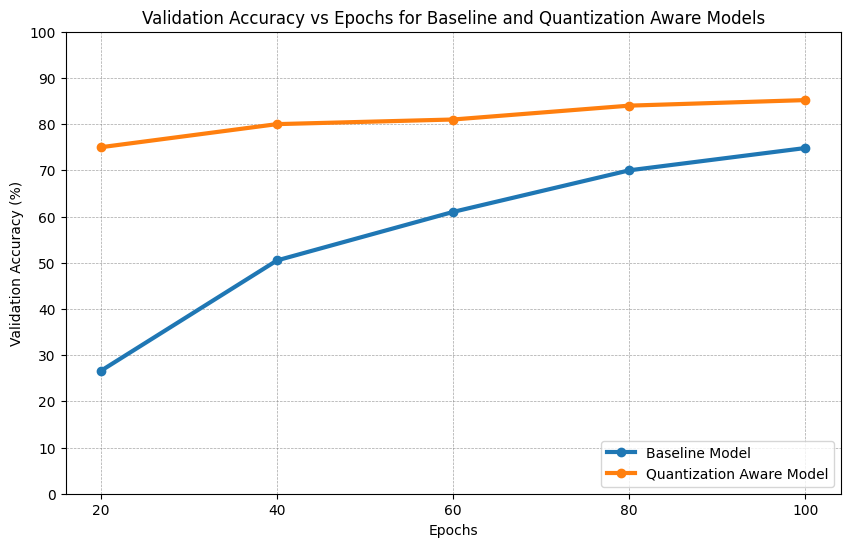

In [5]:
import matplotlib.pyplot as plt

# Data
epochs = [20, 40, 60, 80, 100]
baseline_val_acc = [26.6, 50.5, 61, 70, 74.83]
quant_aware_val_acc = [75, 80, 81, 84, 85.2]

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(epochs, baseline_val_acc, label='Baseline Model', linewidth=3, marker='o')
plt.plot(epochs, quant_aware_val_acc, label='Quantization Aware Model', linewidth=3, marker='o')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy vs Epochs for Baseline and Quantization Aware Models')
plt.xticks(epochs)
plt.yticks(range(0, 101, 10))

# Add lighter grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Add legend
plt.legend(loc='lower right')

# Display the plot
plt.show()


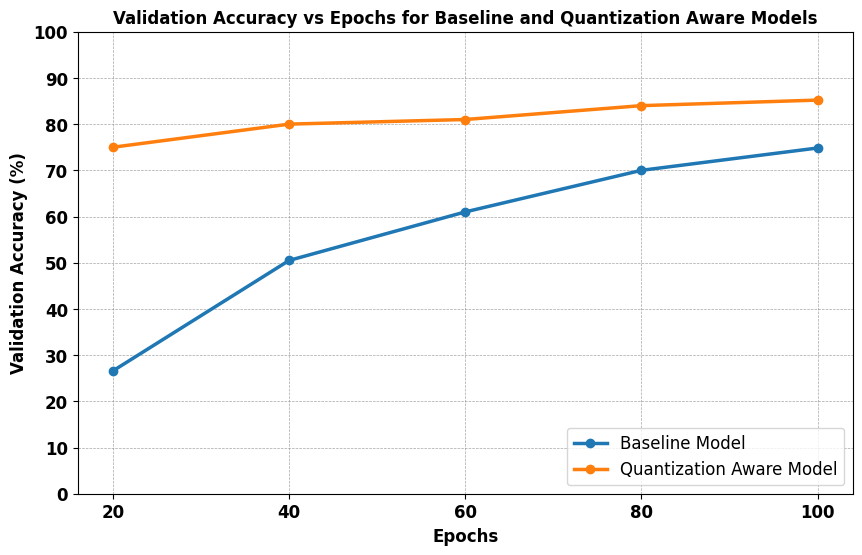

In [11]:
import matplotlib.pyplot as plt

# Data
epochs = [20, 40, 60, 80, 100]
baseline_val_acc = [26.6, 50.5, 61, 70, 74.83]
quant_aware_val_acc = [75, 80, 81, 84, 85.2]

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(epochs, baseline_val_acc, label='Baseline Model', linewidth=2.5, marker='o')
plt.plot(epochs, quant_aware_val_acc, label='Quantization Aware Model', linewidth=2.5, marker='o')

# Adding labels and title with bolder font
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Validation Accuracy vs Epochs for Baseline and Quantization Aware Models', fontsize=12, fontweight='bold')
plt.xticks(epochs, fontsize=12, fontweight='bold')
plt.yticks(range(0, 101, 10), fontsize=12, fontweight='bold')

# Add grid with lighter lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey', alpha=0.7)

# Add legend
plt.legend(loc='lower right', fontsize=12)

# Display the plot
plt.show()
